# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('etau_tree', {'root_raw/et18_raw/ggH_bbtt*.root', 'root_raw/et18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('etau_tree',  {'root_raw/et17_raw/ggH_bbtt*.root', 'root_raw/et17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('etau_tree', {'root_raw/et16_raw/ggH_bbtt*.root', 'root_raw/et16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 1b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770 && bpt_deepflavour_2<0')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033 && bpt_deepflavour_2<0')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093 && bpt_deepflavour_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mytau+mymet).Pt(),(myele+mytau+mymet).Eta(),(myele+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
m_btt = '(mytt+myb1).M()'
m_b1ele = '(myele+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mytau)'
dR_b1ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_ele = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt(),2)+pow(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mytau.Px())*x_zeta+(myele.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 ele+tau trigger requirements
trigger32_18 = '(passEle32 && pt_1>33 && matchEle32_1 && filterEle32_1)'
trigger35_18 = '(passEle35 && pt_1>33 && matchEle35_1 && filterEle35_1)'
trigger2430_18 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_18 = '(passEle24HPSTau30 && matchEle24HPSTau30_1 && filterEle24HPSTau30_1 && matchEle24HPSTau30_2 && filterEle24HPSTau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_emb_18 = '(matchEmbFilter_Ele24Tau30_1 && matchEmbFilter_Ele24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'

trigger_mc_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_1_18 = trigger2430_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_2_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_emb_18 = trigger2430HPS_emb_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files18[1] = files18[1].Filter('gen_match_1==3 && gen_match_2==5')#reconstructed taus are gen taus
files18[1] = files18[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements 
trigger32_17 = '(passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_17 = '(passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_17 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
# requirements on embedded
trigger32_emb1_17 = '(fabs(eta_1)<1.479 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_emb1_17 = '(fabs(eta_1)<1.479 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_emb1_17 = '(fabs(eta_1)<1.479 && passEle24Tau30 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
triggersingle_emb2_17 = '(fabs(eta_1)>1.479 && ((pt_1>28 && pt_1<40) or (pt_1>40 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1) or (pt_1>40 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)))'
triggercross_emb2_17 = '(fabs(eta_1)>1.479 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger2430_17 + str(' or ') + trigger32_17 + str(' or ') + trigger27_17
trigger_emb_17 = trigger32_emb1_17 + str(' or ') + trigger27_emb1_17 + str(' or ') + trigger2430_emb1_17 + str(' or ') + triggersingle_emb2_17 + str(' or ') + triggercross_emb2_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files17[1] = files17[1].Filter('gen_match_1==3 && gen_match_2==5')#reconstructed taus are gen taus
files17[1] = files17[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger25_16 = '(passEle25 && matchEle25_1 && filterEle25_1 && pt_1>26)'

trigger_all_16 = trigger25_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files16[1] = files16[1].Filter('gen_match_1==3 && gen_match_2==5')#reconstructed taus are gen taus
files16[1] = files16[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'm_btt', 'm_b1ele', 'm_b1tau',\
                'dR_tt', 'dR_b1ele', 'dR_b1tau', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_ele', 'mT_tau', 'mT_b1', 'Dzeta',\
                'bpt_deepflavour_1']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (15304, 15)
ZTT18.shape  : (54815, 15)
TT18.shape   : (224461, 15)
qcd18_1.shape: (25317, 15)
qcd18_2.shape: (58797, 15)

sig17.shape  : (21181, 15)
ZTT17.shape  : (67406, 15)
TT17.shape   : (33901, 15)
qcd17.shape  : (57866, 15)

sig16.shape  : (15268, 15)
ZTT16.shape  : (28681, 15)
TT16.shape   : (203259, 15)
qcd16.shape  : (45359, 15)

sig_allyears.shape: (51753, 16)
ZTT_allyears.shape: (150902, 16)
TT_allyears.shape : (461621, 16)
qcd_allyears.shape: (187339, 16)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 6469, random_state = 20)#12.5%
TT_allyears = TT_allyears.sample(n = 26549, random_state = 20)#51.3%
qcd_allyears = qcd_allyears.sample(n = 18735, random_state = 20)#36.2%

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1       m_btt     m_b1ele     m_b1tau     dR_tt  dR_b1ele  \
0      33.426849   93.420735   71.785650   63.214065  0.445226  2.985491   
1      38.046844   64.634879   79.051100   75.774687  0.493337  1.787083   
2      33.893158   84.701722   62.869186   68.038649  0.417182  1.484138   
3      34.148129   74.065612   84.447922   63.879237  0.421692  2.153853   
4      39.722927  136.481179   83.827889   61.878601  0.460214  3.148262   
...          ...         ...         ...         ...       ...       ...   
2061   52.672653  203.026994  144.777740   26.288041  3.284233  3.393653   
8168   47.847309  230.428497  127.870404   23.368892  3.475297  2.943942   
24089  55.186520  264.791929  155.148635   35.723908  3.533317  3.745040   
43737  73.068909  252.634221  142.704061  109.254566  2.407088  2.783407   
35851  54.145138  258.087987  121.575632   55.872834  3.710605  2.234724   

       dR_b1tau   dR_b1tt       tt_pt    tt_eta      mT_ele     mT_tau 

## Compare input feature distributions between sig and bkg

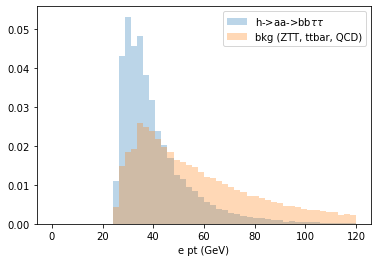

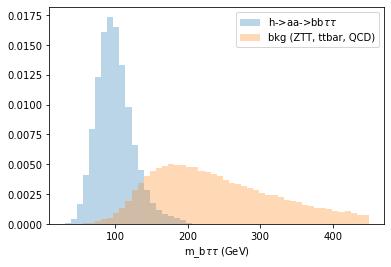

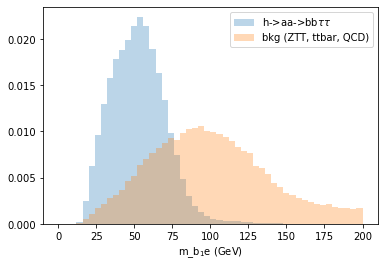

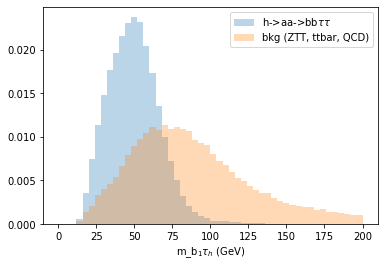

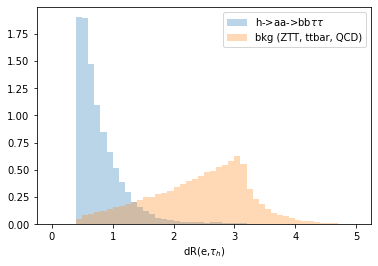

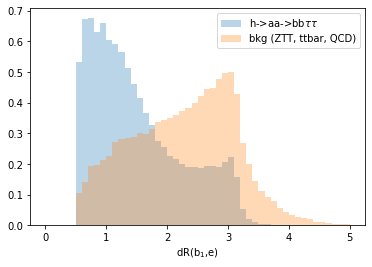

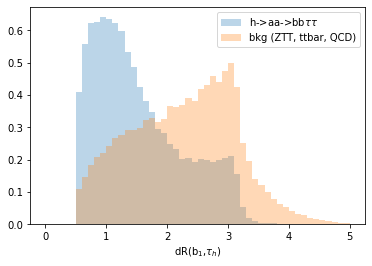

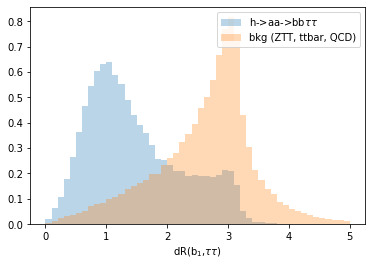

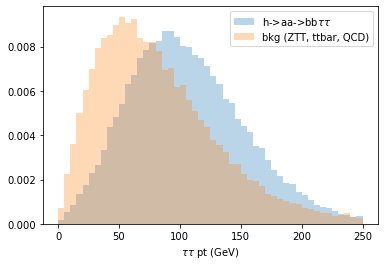

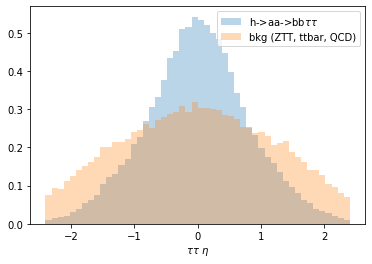

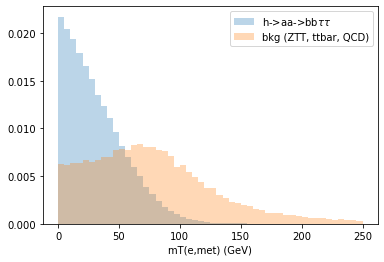

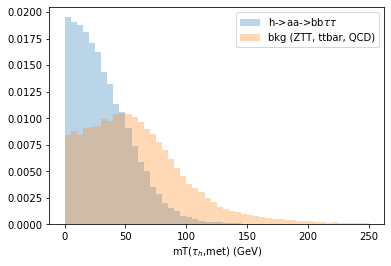

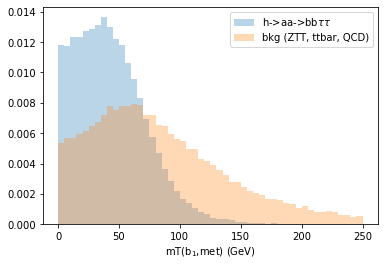

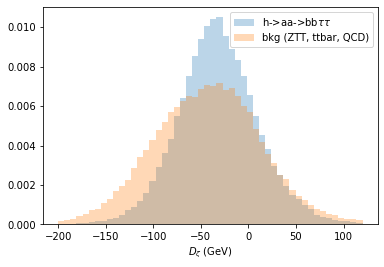

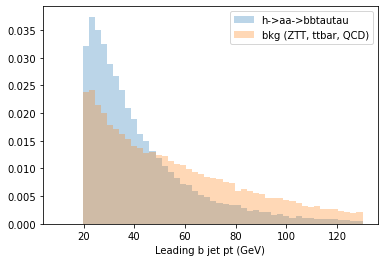

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(sig_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (62103, 15)
Y_train.shape: (62103, 1)
X_val.shape: (20701, 15)
Y_val.shape: (20701, 1)
X_test.shape: (20702, 15)
Y_test.shape: (20702, 1)

Total number of sig/bkg examples: 51753/51753 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 31144/30959 (50.1%/49.9%)
val   : 10299/10402 (49.8%/50.2%)
test  : 10310/10392 (49.8%/50.2%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-08-28 12:04:22.496258: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-28 12:04:22.496627: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 256)

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:41 - loss: 0.7726 - accuracy: 0.51 - ETA: 21s - loss: 0.7115 - accuracy: 0.5684 - ETA: 11s - loss: 0.6433 - accuracy: 0.643 - ETA: 7s - loss: 0.5941 - accuracy: 0.700 - ETA: 6s - loss: 0.5460 - accuracy: 0.74 - ETA: 5s - loss: 0.5120 - accuracy: 0.77 - ETA: 4s - loss: 0.4754 - accuracy: 0.80 - ETA: 3s - loss: 0.4428 - accuracy: 0.82 - ETA: 3s - loss: 0.4201 - accuracy: 0.83 - ETA: 3s - loss: 0.3971 - accuracy: 0.84 - ETA: 2s - loss: 0.3740 - accuracy: 0.85 - ETA: 2s - loss: 0.3564 - accuracy: 0.86 - ETA: 2s - loss: 0.3391 - accuracy: 0.87 - ETA: 2s - loss: 0.3264 - accuracy: 0.87 - ETA: 1s - loss: 0.3126 - accuracy: 0.88 - ETA: 1s - loss: 0.3015 - accuracy: 0.88 - ETA: 1s - loss: 0.2920 - accuracy: 0.89 - ETA: 1s - loss: 0.2834 - accuracy: 0.89 - ETA: 1s - loss: 0.2761 - accuracy: 0.89 - ETA: 1s - loss: 0.2683 - accuracy: 0.90 - ETA: 1s - loss: 0.2612 - accuracy: 0.90 - ETA

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.9487 - accuracy: 0.41 - ETA: 11s - loss: 0.8464 - accuracy: 0.4499 - ETA: 6s - loss: 0.7938 - accuracy: 0.507 - ETA: 5s - loss: 0.7513 - accuracy: 0.54 - ETA: 4s - loss: 0.7107 - accuracy: 0.58 - ETA: 3s - loss: 0.6698 - accuracy: 0.62 - ETA: 2s - loss: 0.6353 - accuracy: 0.65 - ETA: 2s - loss: 0.6044 - accuracy: 0.68 - ETA: 2s - loss: 0.5780 - accuracy: 0.70 - ETA: 1s - loss: 0.5527 - accuracy: 0.72 - ETA: 1s - loss: 0.5279 - accuracy: 0.73 - ETA: 1s - loss: 0.5169 - accuracy: 0.74 - ETA: 1s - loss: 0.4979 - accuracy: 0.75 - ETA: 1s - loss: 0.4801 - accuracy: 0.76 - ETA: 1s - loss: 0.4632 - accuracy: 0.77 - ETA: 1s - loss: 0.4490 - accuracy: 0.78 - ETA: 0s - loss: 0.4350 - accuracy: 0.79 - ETA: 0s - loss: 0.4222 - accuracy: 0.80 - ETA: 0s - loss: 0.4098 - accuracy: 0.81 - ETA: 0s - loss: 0.3995 - accuracy: 0.81 - ETA: 0s - loss: 0.3895 - accuracy: 0.82 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:02 - loss: 0.7448 - accuracy: 0.47 - ETA: 14s - loss: 0.6762 - accuracy: 0.5534 - ETA: 8s - loss: 0.6237 - accuracy: 0.622 - ETA: 5s - loss: 0.5832 - accuracy: 0.67 - ETA: 4s - loss: 0.5503 - accuracy: 0.71 - ETA: 3s - loss: 0.5207 - accuracy: 0.74 - ETA: 3s - loss: 0.4917 - accuracy: 0.77 - ETA: 2s - loss: 0.4668 - accuracy: 0.78 - ETA: 2s - loss: 0.4440 - accuracy: 0.80 - ETA: 2s - loss: 0.4249 - accuracy: 0.81 - ETA: 2s - loss: 0.4064 - accuracy: 0.82 - ETA: 1s - loss: 0.3922 - accuracy: 0.83 - ETA: 1s - loss: 0.3772 - accuracy: 0.83 - ETA: 1s - loss: 0.3636 - accuracy: 0.84 - ETA: 1s - loss: 0.3515 - accuracy: 0.85 - ETA: 1s - loss: 0.3389 - accuracy: 0.85 - ETA: 1s - loss: 0.3299 - accuracy: 0.86 - ETA: 1s - loss: 0.3202 - accuracy: 0.86 - ETA: 1s - loss: 0.3117 - accuracy: 0.87 - ETA: 0s - loss: 0.3046 - accuracy: 0.87 - ETA: 0s - loss: 0.2966 - accuracy: 0.87 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8011 - accuracy: 0.45 - ETA: 16s - loss: 0.6910 - accuracy: 0.5776 - ETA: 9s - loss: 0.6309 - accuracy: 0.650 - ETA: 6s - loss: 0.5828 - accuracy: 0.69 - ETA: 5s - loss: 0.5403 - accuracy: 0.73 - ETA: 4s - loss: 0.5058 - accuracy: 0.75 - ETA: 3s - loss: 0.4749 - accuracy: 0.77 - ETA: 3s - loss: 0.4492 - accuracy: 0.79 - ETA: 3s - loss: 0.4285 - accuracy: 0.80 - ETA: 2s - loss: 0.4093 - accuracy: 0.81 - ETA: 2s - loss: 0.3906 - accuracy: 0.82 - ETA: 2s - loss: 0.3772 - accuracy: 0.83 - ETA: 2s - loss: 0.3634 - accuracy: 0.84 - ETA: 2s - loss: 0.3494 - accuracy: 0.85 - ETA: 1s - loss: 0.3374 - accuracy: 0.85 - ETA: 1s - loss: 0.3266 - accuracy: 0.86 - ETA: 1s - loss: 0.3176 - accuracy: 0.86 - ETA: 1s - loss: 0.3099 - accuracy: 0.86 - ETA: 1s - loss: 0.3040 - accuracy: 0.87 - ETA: 1s - loss: 0.2987 - accuracy: 0.87 - ETA: 1s - loss: 0.2913 - accuracy: 0.87 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:07 - loss: 0.9904 - accuracy: 0.51 - ETA: 13s - loss: 0.8340 - accuracy: 0.5434 - ETA: 7s - loss: 0.7587 - accuracy: 0.576 - ETA: 5s - loss: 0.7005 - accuracy: 0.61 - ETA: 4s - loss: 0.6458 - accuracy: 0.65 - ETA: 3s - loss: 0.6062 - accuracy: 0.68 - ETA: 3s - loss: 0.5673 - accuracy: 0.71 - ETA: 2s - loss: 0.5377 - accuracy: 0.73 - ETA: 2s - loss: 0.5061 - accuracy: 0.75 - ETA: 2s - loss: 0.4799 - accuracy: 0.77 - ETA: 1s - loss: 0.4580 - accuracy: 0.78 - ETA: 1s - loss: 0.4395 - accuracy: 0.79 - ETA: 1s - loss: 0.4213 - accuracy: 0.81 - ETA: 1s - loss: 0.4072 - accuracy: 0.81 - ETA: 1s - loss: 0.3935 - accuracy: 0.82 - ETA: 1s - loss: 0.3799 - accuracy: 0.83 - ETA: 1s - loss: 0.3676 - accuracy: 0.83 - ETA: 0s - loss: 0.3564 - accuracy: 0.84 - ETA: 0s - loss: 0.3469 - accuracy: 0.85 - ETA: 0s - loss: 0.3364 - accuracy: 0.85 - ETA: 0s - loss: 0.3270 - accuracy: 0.86 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:02 - loss: 0.6918 - accuracy: 0.53 - ETA: 14s - loss: 0.6522 - accuracy: 0.5881 - ETA: 8s - loss: 0.6039 - accuracy: 0.655 - ETA: 5s - loss: 0.5565 - accuracy: 0.71 - ETA: 4s - loss: 0.5201 - accuracy: 0.74 - ETA: 3s - loss: 0.4872 - accuracy: 0.77 - ETA: 3s - loss: 0.4556 - accuracy: 0.79 - ETA: 2s - loss: 0.4300 - accuracy: 0.81 - ETA: 2s - loss: 0.4060 - accuracy: 0.82 - ETA: 2s - loss: 0.3869 - accuracy: 0.83 - ETA: 1s - loss: 0.3681 - accuracy: 0.84 - ETA: 1s - loss: 0.3511 - accuracy: 0.85 - ETA: 1s - loss: 0.3369 - accuracy: 0.86 - ETA: 1s - loss: 0.3243 - accuracy: 0.86 - ETA: 1s - loss: 0.3131 - accuracy: 0.87 - ETA: 1s - loss: 0.3032 - accuracy: 0.87 - ETA: 1s - loss: 0.2947 - accuracy: 0.88 - ETA: 0s - loss: 0.2857 - accuracy: 0.88 - ETA: 0s - loss: 0.2768 - accuracy: 0.89 - ETA: 0s - loss: 0.2694 - accuracy: 0.89 - ETA: 0s - loss: 0.2630 - accuracy: 0.89 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8119 - accuracy: 0.46 - ETA: 14s - loss: 0.7197 - accuracy: 0.5074 - ETA: 7s - loss: 0.6676 - accuracy: 0.559 - ETA: 5s - loss: 0.6355 - accuracy: 0.60 - ETA: 4s - loss: 0.6012 - accuracy: 0.65 - ETA: 3s - loss: 0.5692 - accuracy: 0.68 - ETA: 3s - loss: 0.5427 - accuracy: 0.71 - ETA: 2s - loss: 0.5174 - accuracy: 0.73 - ETA: 2s - loss: 0.4931 - accuracy: 0.75 - ETA: 2s - loss: 0.4693 - accuracy: 0.77 - ETA: 1s - loss: 0.4475 - accuracy: 0.78 - ETA: 1s - loss: 0.4311 - accuracy: 0.79 - ETA: 1s - loss: 0.4133 - accuracy: 0.80 - ETA: 1s - loss: 0.3976 - accuracy: 0.81 - ETA: 1s - loss: 0.3813 - accuracy: 0.82 - ETA: 1s - loss: 0.3674 - accuracy: 0.83 - ETA: 1s - loss: 0.3550 - accuracy: 0.84 - ETA: 1s - loss: 0.3438 - accuracy: 0.84 - ETA: 0s - loss: 0.3337 - accuracy: 0.85 - ETA: 0s - loss: 0.3246 - accuracy: 0.85 - ETA: 0s - loss: 0.3157 - accuracy: 0.86 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:02 - loss: 0.6858 - accuracy: 0.56 - ETA: 14s - loss: 0.6367 - accuracy: 0.6259 - ETA: 8s - loss: 0.5853 - accuracy: 0.707 - ETA: 5s - loss: 0.5376 - accuracy: 0.75 - ETA: 4s - loss: 0.4939 - accuracy: 0.79 - ETA: 3s - loss: 0.4630 - accuracy: 0.81 - ETA: 3s - loss: 0.4323 - accuracy: 0.82 - ETA: 2s - loss: 0.4041 - accuracy: 0.84 - ETA: 2s - loss: 0.3784 - accuracy: 0.85 - ETA: 2s - loss: 0.3577 - accuracy: 0.86 - ETA: 2s - loss: 0.3405 - accuracy: 0.87 - ETA: 1s - loss: 0.3259 - accuracy: 0.87 - ETA: 1s - loss: 0.3115 - accuracy: 0.88 - ETA: 1s - loss: 0.3000 - accuracy: 0.88 - ETA: 1s - loss: 0.2897 - accuracy: 0.89 - ETA: 1s - loss: 0.2810 - accuracy: 0.89 - ETA: 1s - loss: 0.2718 - accuracy: 0.89 - ETA: 1s - loss: 0.2627 - accuracy: 0.90 - ETA: 1s - loss: 0.2558 - accuracy: 0.90 - ETA: 0s - loss: 0.2498 - accuracy: 0.90 - ETA: 0s - loss: 0.2443 - accuracy: 0.91 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6554 - accuracy: 0.60 - ETA: 14s - loss: 0.5983 - accuracy: 0.6871 - ETA: 8s - loss: 0.5479 - accuracy: 0.742 - ETA: 5s - loss: 0.5039 - accuracy: 0.78 - ETA: 4s - loss: 0.4638 - accuracy: 0.80 - ETA: 3s - loss: 0.4295 - accuracy: 0.83 - ETA: 3s - loss: 0.4021 - accuracy: 0.84 - ETA: 2s - loss: 0.3777 - accuracy: 0.85 - ETA: 2s - loss: 0.3574 - accuracy: 0.86 - ETA: 2s - loss: 0.3393 - accuracy: 0.87 - ETA: 2s - loss: 0.3211 - accuracy: 0.87 - ETA: 1s - loss: 0.3091 - accuracy: 0.88 - ETA: 1s - loss: 0.2964 - accuracy: 0.88 - ETA: 1s - loss: 0.2845 - accuracy: 0.89 - ETA: 1s - loss: 0.2750 - accuracy: 0.89 - ETA: 1s - loss: 0.2655 - accuracy: 0.90 - ETA: 1s - loss: 0.2580 - accuracy: 0.90 - ETA: 1s - loss: 0.2505 - accuracy: 0.90 - ETA: 0s - loss: 0.2451 - accuracy: 0.90 - ETA: 0s - loss: 0.2384 - accuracy: 0.91 - ETA: 0s - loss: 0.2321 - accuracy: 0.91 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8548 - accuracy: 0.53 - ETA: 14s - loss: 0.7257 - accuracy: 0.5829 - ETA: 8s - loss: 0.6534 - accuracy: 0.654 - ETA: 6s - loss: 0.5950 - accuracy: 0.71 - ETA: 4s - loss: 0.5421 - accuracy: 0.75 - ETA: 4s - loss: 0.4992 - accuracy: 0.78 - ETA: 3s - loss: 0.4632 - accuracy: 0.80 - ETA: 3s - loss: 0.4357 - accuracy: 0.82 - ETA: 2s - loss: 0.4124 - accuracy: 0.83 - ETA: 2s - loss: 0.3916 - accuracy: 0.84 - ETA: 2s - loss: 0.3724 - accuracy: 0.85 - ETA: 2s - loss: 0.3562 - accuracy: 0.86 - ETA: 1s - loss: 0.3423 - accuracy: 0.86 - ETA: 1s - loss: 0.3280 - accuracy: 0.87 - ETA: 1s - loss: 0.3159 - accuracy: 0.87 - ETA: 1s - loss: 0.3047 - accuracy: 0.88 - ETA: 1s - loss: 0.2940 - accuracy: 0.88 - ETA: 1s - loss: 0.2846 - accuracy: 0.89 - ETA: 1s - loss: 0.2771 - accuracy: 0.89 - ETA: 1s - loss: 0.2685 - accuracy: 0.89 - ETA: 1s - loss: 0.2601 - accuracy: 0.90 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8856 - accuracy: 0.49 - ETA: 16s - loss: 0.7630 - accuracy: 0.5527 - ETA: 9s - loss: 0.6844 - accuracy: 0.604 - ETA: 6s - loss: 0.6225 - accuracy: 0.66 - ETA: 5s - loss: 0.5726 - accuracy: 0.70 - ETA: 4s - loss: 0.5269 - accuracy: 0.73 - ETA: 3s - loss: 0.4921 - accuracy: 0.76 - ETA: 3s - loss: 0.4637 - accuracy: 0.78 - ETA: 2s - loss: 0.4334 - accuracy: 0.80 - ETA: 2s - loss: 0.4119 - accuracy: 0.81 - ETA: 2s - loss: 0.3923 - accuracy: 0.82 - ETA: 2s - loss: 0.3748 - accuracy: 0.83 - ETA: 2s - loss: 0.3600 - accuracy: 0.84 - ETA: 1s - loss: 0.3454 - accuracy: 0.85 - ETA: 1s - loss: 0.3310 - accuracy: 0.85 - ETA: 1s - loss: 0.3208 - accuracy: 0.86 - ETA: 1s - loss: 0.3098 - accuracy: 0.87 - ETA: 1s - loss: 0.3008 - accuracy: 0.87 - ETA: 1s - loss: 0.2921 - accuracy: 0.87 - ETA: 1s - loss: 0.2843 - accuracy: 0.88 - ETA: 1s - loss: 0.2755 - accuracy: 0.88 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6558 - accuracy: 0.58 - ETA: 16s - loss: 0.5721 - accuracy: 0.7202 - ETA: 9s - loss: 0.5130 - accuracy: 0.786 - ETA: 6s - loss: 0.4675 - accuracy: 0.81 - ETA: 5s - loss: 0.4291 - accuracy: 0.84 - ETA: 4s - loss: 0.3936 - accuracy: 0.85 - ETA: 3s - loss: 0.3665 - accuracy: 0.86 - ETA: 3s - loss: 0.3428 - accuracy: 0.87 - ETA: 3s - loss: 0.3244 - accuracy: 0.88 - ETA: 2s - loss: 0.3098 - accuracy: 0.88 - ETA: 2s - loss: 0.2959 - accuracy: 0.89 - ETA: 2s - loss: 0.2840 - accuracy: 0.89 - ETA: 2s - loss: 0.2716 - accuracy: 0.90 - ETA: 2s - loss: 0.2607 - accuracy: 0.90 - ETA: 1s - loss: 0.2508 - accuracy: 0.91 - ETA: 1s - loss: 0.2416 - accuracy: 0.91 - ETA: 1s - loss: 0.2339 - accuracy: 0.91 - ETA: 1s - loss: 0.2285 - accuracy: 0.91 - ETA: 1s - loss: 0.2227 - accuracy: 0.92 - ETA: 1s - loss: 0.2174 - accuracy: 0.92 - ETA: 1s - loss: 0.2118 - accuracy: 0.92 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6488 - accuracy: 0.60 - ETA: 16s - loss: 0.5556 - accuracy: 0.7700 - ETA: 9s - loss: 0.4946 - accuracy: 0.824 - ETA: 6s - loss: 0.4480 - accuracy: 0.85 - ETA: 5s - loss: 0.4127 - accuracy: 0.86 - ETA: 4s - loss: 0.3782 - accuracy: 0.88 - ETA: 3s - loss: 0.3506 - accuracy: 0.89 - ETA: 3s - loss: 0.3262 - accuracy: 0.89 - ETA: 3s - loss: 0.3066 - accuracy: 0.90 - ETA: 2s - loss: 0.2884 - accuracy: 0.91 - ETA: 2s - loss: 0.2725 - accuracy: 0.91 - ETA: 2s - loss: 0.2596 - accuracy: 0.91 - ETA: 2s - loss: 0.2481 - accuracy: 0.92 - ETA: 1s - loss: 0.2387 - accuracy: 0.92 - ETA: 1s - loss: 0.2306 - accuracy: 0.92 - ETA: 1s - loss: 0.2240 - accuracy: 0.92 - ETA: 1s - loss: 0.2171 - accuracy: 0.93 - ETA: 1s - loss: 0.2114 - accuracy: 0.93 - ETA: 1s - loss: 0.2063 - accuracy: 0.93 - ETA: 1s - loss: 0.2012 - accuracy: 0.93 - ETA: 1s - loss: 0.1964 - accuracy: 0.93 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6351 - accuracy: 0.60 - ETA: 16s - loss: 0.5925 - accuracy: 0.6865 - ETA: 9s - loss: 0.5545 - accuracy: 0.733 - ETA: 6s - loss: 0.5205 - accuracy: 0.76 - ETA: 5s - loss: 0.4828 - accuracy: 0.79 - ETA: 4s - loss: 0.4536 - accuracy: 0.81 - ETA: 3s - loss: 0.4243 - accuracy: 0.83 - ETA: 3s - loss: 0.4003 - accuracy: 0.84 - ETA: 2s - loss: 0.3765 - accuracy: 0.85 - ETA: 2s - loss: 0.3566 - accuracy: 0.86 - ETA: 2s - loss: 0.3409 - accuracy: 0.87 - ETA: 2s - loss: 0.3261 - accuracy: 0.87 - ETA: 2s - loss: 0.3135 - accuracy: 0.88 - ETA: 1s - loss: 0.3002 - accuracy: 0.88 - ETA: 1s - loss: 0.2889 - accuracy: 0.89 - ETA: 1s - loss: 0.2799 - accuracy: 0.89 - ETA: 1s - loss: 0.2707 - accuracy: 0.89 - ETA: 1s - loss: 0.2631 - accuracy: 0.90 - ETA: 1s - loss: 0.2562 - accuracy: 0.90 - ETA: 1s - loss: 0.2479 - accuracy: 0.90 - ETA: 1s - loss: 0.2433 - accuracy: 0.91 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:02 - loss: 0.8185 - accuracy: 0.36 - ETA: 14s - loss: 0.7386 - accuracy: 0.4779 - ETA: 8s - loss: 0.6625 - accuracy: 0.591 - ETA: 5s - loss: 0.6034 - accuracy: 0.66 - ETA: 4s - loss: 0.5514 - accuracy: 0.71 - ETA: 3s - loss: 0.5108 - accuracy: 0.75 - ETA: 3s - loss: 0.4746 - accuracy: 0.77 - ETA: 2s - loss: 0.4427 - accuracy: 0.79 - ETA: 2s - loss: 0.4140 - accuracy: 0.81 - ETA: 2s - loss: 0.3921 - accuracy: 0.82 - ETA: 2s - loss: 0.3710 - accuracy: 0.83 - ETA: 1s - loss: 0.3510 - accuracy: 0.84 - ETA: 1s - loss: 0.3345 - accuracy: 0.85 - ETA: 1s - loss: 0.3200 - accuracy: 0.86 - ETA: 1s - loss: 0.3067 - accuracy: 0.87 - ETA: 1s - loss: 0.2949 - accuracy: 0.87 - ETA: 1s - loss: 0.2851 - accuracy: 0.88 - ETA: 1s - loss: 0.2759 - accuracy: 0.88 - ETA: 0s - loss: 0.2678 - accuracy: 0.88 - ETA: 0s - loss: 0.2596 - accuracy: 0.89 - ETA: 0s - loss: 0.2525 - accuracy: 0.89 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7444 - accuracy: 0.49 - ETA: 14s - loss: 0.6875 - accuracy: 0.5213 - ETA: 7s - loss: 0.6283 - accuracy: 0.595 - ETA: 5s - loss: 0.5890 - accuracy: 0.65 - ETA: 4s - loss: 0.5504 - accuracy: 0.70 - ETA: 3s - loss: 0.5161 - accuracy: 0.73 - ETA: 3s - loss: 0.4840 - accuracy: 0.76 - ETA: 2s - loss: 0.4555 - accuracy: 0.78 - ETA: 2s - loss: 0.4297 - accuracy: 0.80 - ETA: 2s - loss: 0.4070 - accuracy: 0.81 - ETA: 2s - loss: 0.3859 - accuracy: 0.83 - ETA: 1s - loss: 0.3711 - accuracy: 0.83 - ETA: 1s - loss: 0.3521 - accuracy: 0.84 - ETA: 1s - loss: 0.3372 - accuracy: 0.85 - ETA: 1s - loss: 0.3245 - accuracy: 0.86 - ETA: 1s - loss: 0.3120 - accuracy: 0.86 - ETA: 1s - loss: 0.3017 - accuracy: 0.87 - ETA: 1s - loss: 0.2934 - accuracy: 0.87 - ETA: 0s - loss: 0.2827 - accuracy: 0.88 - ETA: 0s - loss: 0.2747 - accuracy: 0.88 - ETA: 0s - loss: 0.2673 - accuracy: 0.88 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6998 - accuracy: 0.48 - ETA: 16s - loss: 0.6163 - accuracy: 0.6895 - ETA: 9s - loss: 0.5583 - accuracy: 0.761 - ETA: 6s - loss: 0.5042 - accuracy: 0.80 - ETA: 5s - loss: 0.4587 - accuracy: 0.83 - ETA: 4s - loss: 0.4209 - accuracy: 0.84 - ETA: 3s - loss: 0.3875 - accuracy: 0.86 - ETA: 3s - loss: 0.3599 - accuracy: 0.87 - ETA: 3s - loss: 0.3350 - accuracy: 0.88 - ETA: 2s - loss: 0.3161 - accuracy: 0.88 - ETA: 2s - loss: 0.2992 - accuracy: 0.89 - ETA: 2s - loss: 0.2865 - accuracy: 0.90 - ETA: 2s - loss: 0.2726 - accuracy: 0.90 - ETA: 2s - loss: 0.2612 - accuracy: 0.90 - ETA: 1s - loss: 0.2507 - accuracy: 0.91 - ETA: 1s - loss: 0.2418 - accuracy: 0.91 - ETA: 1s - loss: 0.2335 - accuracy: 0.91 - ETA: 1s - loss: 0.2270 - accuracy: 0.92 - ETA: 1s - loss: 0.2199 - accuracy: 0.92 - ETA: 1s - loss: 0.2138 - accuracy: 0.92 - ETA: 1s - loss: 0.2093 - accuracy: 0.92 - ETA:

Epoch 13/20
62103/62103 [==============================] - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 1s - loss: 0.0737 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0814 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0834 - accuracy: 0.97 - ETA: 1s - loss: 0.0832 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0834 - accuracy: 0.97 - ETA: 1s - loss: 0.0838 - accuracy: 0.97 - ETA: 1s - loss: 0.0847 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0848 - accuracy: 0.97 - ETA: 1s - loss: 0.0849 - accuracy: 0.96 - ETA: 1s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0842 - accuracy: 0.97 - ETA: 0s - loss: 0.0847 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0

62103/62103 [==============================] - ETA: 2s - loss: 0.0568 - accuracy: 0.98 - ETA: 1s - loss: 0.0810 - accuracy: 0.97 - ETA: 1s - loss: 0.0769 - accuracy: 0.97 - ETA: 1s - loss: 0.0777 - accuracy: 0.97 - ETA: 1s - loss: 0.0778 - accuracy: 0.97 - ETA: 1s - loss: 0.0771 - accuracy: 0.97 - ETA: 1s - loss: 0.0789 - accuracy: 0.97 - ETA: 1s - loss: 0.0781 - accuracy: 0.97 - ETA: 1s - loss: 0.0781 - accuracy: 0.97 - ETA: 1s - loss: 0.0770 - accuracy: 0.97 - ETA: 1s - loss: 0.0768 - accuracy: 0.97 - ETA: 1s - loss: 0.0775 - accuracy: 0.97 - ETA: 1s - loss: 0.0767 - accuracy: 0.97 - ETA: 1s - loss: 0.0762 - accuracy: 0.97 - ETA: 1s - loss: 0.0751 - accuracy: 0.97 - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - ETA: 0s - loss: 0.0762 - accuracy: 0.97 - ETA: 0s - loss: 0.0765 - accuracy: 0.97 - ETA: 0s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0767 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8196 - accuracy: 0.50 - ETA: 13s - loss: 0.6854 - accuracy: 0.6102 - ETA: 7s - loss: 0.6289 - accuracy: 0.667 - ETA: 5s - loss: 0.5800 - accuracy: 0.71 - ETA: 4s - loss: 0.5412 - accuracy: 0.74 - ETA: 3s - loss: 0.5024 - accuracy: 0.77 - ETA: 3s - loss: 0.4679 - accuracy: 0.79 - ETA: 2s - loss: 0.4387 - accuracy: 0.81 - ETA: 2s - loss: 0.4152 - accuracy: 0.82 - ETA: 2s - loss: 0.3922 - accuracy: 0.83 - ETA: 1s - loss: 0.3741 - accuracy: 0.84 - ETA: 1s - loss: 0.3584 - accuracy: 0.85 - ETA: 1s - loss: 0.3437 - accuracy: 0.86 - ETA: 1s - loss: 0.3299 - accuracy: 0.86 - ETA: 1s - loss: 0.3178 - accuracy: 0.87 - ETA: 1s - loss: 0.3061 - accuracy: 0.87 - ETA: 1s - loss: 0.2947 - accuracy: 0.88 - ETA: 0s - loss: 0.2862 - accuracy: 0.88 - ETA: 0s - loss: 0.2779 - accuracy: 0.89 - ETA: 0s - loss: 0.2715 - accuracy: 0.89 - ETA: 0s - loss: 0.2639 - accuracy: 0.89 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.0976 - accuracy: 0.96 - ETA: 1s - loss: 0.0998 - accuracy: 0.96 - ETA: 1s - loss: 0.0997 - accuracy: 0.96 - ETA: 1s - loss: 0.0955 - accuracy: 0.96 - ETA: 1s - loss: 0.0969 - accuracy: 0.96 - ETA: 1s - loss: 0.0996 - accuracy: 0.96 - ETA: 1s - loss: 0.1016 - accuracy: 0.96 - ETA: 1s - loss: 0.1007 - accuracy: 0.96 - ETA: 1s - loss: 0.0989 - accuracy: 0.96 - ETA: 1s - loss: 0.0980 - accuracy: 0.96 - ETA: 1s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0653 - accuracy: 0.97 - ETA: 1s - loss: 0.0786 - accuracy: 0.97 - ETA: 1s - loss: 0.0791 - accuracy: 0.97 - ETA: 1s - loss: 0.0829 - accuracy: 0.97 - ETA: 1s - loss: 0.0805 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0838 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0848 - accuracy: 0.97 - ETA: 1s - loss: 0.0858 - accuracy: 0.97 - ETA: 1s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.0847 - accuracy: 0.97 - ETA: 0s - loss: 0.0845 - accuracy: 0.97 - ETA: 0s - loss: 0.0845 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8268 - accuracy: 0.29 - ETA: 14s - loss: 0.7422 - accuracy: 0.4783 - ETA: 8s - loss: 0.6832 - accuracy: 0.571 - ETA: 5s - loss: 0.6345 - accuracy: 0.63 - ETA: 4s - loss: 0.5913 - accuracy: 0.68 - ETA: 3s - loss: 0.5555 - accuracy: 0.72 - ETA: 3s - loss: 0.5232 - accuracy: 0.74 - ETA: 2s - loss: 0.4937 - accuracy: 0.77 - ETA: 2s - loss: 0.4673 - accuracy: 0.78 - ETA: 2s - loss: 0.4449 - accuracy: 0.80 - ETA: 2s - loss: 0.4211 - accuracy: 0.81 - ETA: 1s - loss: 0.4012 - accuracy: 0.82 - ETA: 1s - loss: 0.3849 - accuracy: 0.83 - ETA: 1s - loss: 0.3693 - accuracy: 0.84 - ETA: 1s - loss: 0.3553 - accuracy: 0.85 - ETA: 1s - loss: 0.3421 - accuracy: 0.85 - ETA: 1s - loss: 0.3304 - accuracy: 0.86 - ETA: 1s - loss: 0.3201 - accuracy: 0.86 - ETA: 0s - loss: 0.3112 - accuracy: 0.87 - ETA: 0s - loss: 0.3025 - accuracy: 0.87 - ETA: 0s - loss: 0.2936 - accuracy: 0.87 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.1367 - accuracy: 0.95 - ETA: 1s - loss: 0.0938 - accuracy: 0.96 - ETA: 1s - loss: 0.0953 - accuracy: 0.96 - ETA: 1s - loss: 0.0944 - accuracy: 0.96 - ETA: 1s - loss: 0.0963 - accuracy: 0.96 - ETA: 1s - loss: 0.0949 - accuracy: 0.96 - ETA: 1s - loss: 0.0953 - accuracy: 0.96 - ETA: 1s - loss: 0.0943 - accuracy: 0.96 - ETA: 1s - loss: 0.0948 - accuracy: 0.96 - ETA: 1s - loss: 0.0923 - accuracy: 0.96 - ETA: 1s - loss: 0.0926 - accuracy: 0.96 - ETA: 1s - loss: 0.0927 - accuracy: 0.96 - ETA: 1s - loss: 0.0926 - accuracy: 0.96 - ETA: 1s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0915 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0912 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7291 - accuracy: 0.48 - ETA: 14s - loss: 0.6399 - accuracy: 0.5829 - ETA: 8s - loss: 0.5756 - accuracy: 0.678 - ETA: 5s - loss: 0.5230 - accuracy: 0.74 - ETA: 4s - loss: 0.4824 - accuracy: 0.77 - ETA: 3s - loss: 0.4448 - accuracy: 0.80 - ETA: 3s - loss: 0.4176 - accuracy: 0.82 - ETA: 3s - loss: 0.3923 - accuracy: 0.83 - ETA: 2s - loss: 0.3707 - accuracy: 0.84 - ETA: 2s - loss: 0.3519 - accuracy: 0.85 - ETA: 2s - loss: 0.3347 - accuracy: 0.86 - ETA: 2s - loss: 0.3221 - accuracy: 0.87 - ETA: 1s - loss: 0.3071 - accuracy: 0.87 - ETA: 1s - loss: 0.2942 - accuracy: 0.88 - ETA: 1s - loss: 0.2825 - accuracy: 0.88 - ETA: 1s - loss: 0.2726 - accuracy: 0.89 - ETA: 1s - loss: 0.2643 - accuracy: 0.89 - ETA: 1s - loss: 0.2579 - accuracy: 0.89 - ETA: 1s - loss: 0.2514 - accuracy: 0.90 - ETA: 0s - loss: 0.2450 - accuracy: 0.90 - ETA: 0s - loss: 0.2384 - accuracy: 0.90 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.1263 - accuracy: 0.94 - ETA: 1s - loss: 0.0930 - accuracy: 0.97 - ETA: 1s - loss: 0.0879 - accuracy: 0.97 - ETA: 1s - loss: 0.0852 - accuracy: 0.97 - ETA: 1s - loss: 0.0862 - accuracy: 0.97 - ETA: 1s - loss: 0.0844 - accuracy: 0.97 - ETA: 1s - loss: 0.0840 - accuracy: 0.97 - ETA: 1s - loss: 0.0842 - accuracy: 0.96 - ETA: 1s - loss: 0.0827 - accuracy: 0.96 - ETA: 1s - loss: 0.0825 - accuracy: 0.97 - ETA: 1s - loss: 0.0856 - accuracy: 0.96 - ETA: 1s - loss: 0.0867 - accuracy: 0.96 - ETA: 1s - loss: 0.0869 - accuracy: 0.96 - ETA: 0s - loss: 0.0867 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0877 - accuracy: 0.96 - ETA: 0s - loss: 0.0864 - accuracy: 0.96 - ETA: 0s - loss: 0.0858 - accuracy: 0.96 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0876 - accuracy: 0.96 - ETA: 0s - loss: 0.0877 - accuracy: 0.96 - ETA: 0s - loss: 0.0879 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7235 - accuracy: 0.55 - ETA: 13s - loss: 0.6640 - accuracy: 0.6363 - ETA: 7s - loss: 0.6036 - accuracy: 0.704 - ETA: 5s - loss: 0.5543 - accuracy: 0.75 - ETA: 4s - loss: 0.5162 - accuracy: 0.77 - ETA: 3s - loss: 0.4824 - accuracy: 0.80 - ETA: 2s - loss: 0.4520 - accuracy: 0.81 - ETA: 2s - loss: 0.4278 - accuracy: 0.82 - ETA: 2s - loss: 0.4048 - accuracy: 0.84 - ETA: 1s - loss: 0.3848 - accuracy: 0.85 - ETA: 1s - loss: 0.3679 - accuracy: 0.85 - ETA: 1s - loss: 0.3531 - accuracy: 0.86 - ETA: 1s - loss: 0.3397 - accuracy: 0.87 - ETA: 1s - loss: 0.3273 - accuracy: 0.87 - ETA: 1s - loss: 0.3171 - accuracy: 0.87 - ETA: 1s - loss: 0.3066 - accuracy: 0.88 - ETA: 0s - loss: 0.2952 - accuracy: 0.88 - ETA: 0s - loss: 0.2868 - accuracy: 0.89 - ETA: 0s - loss: 0.2791 - accuracy: 0.89 - ETA: 0s - loss: 0.2712 - accuracy: 0.89 - ETA: 0s - loss: 0.2657 - accuracy: 0.90 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.1069 - accuracy: 0.97 - ETA: 1s - loss: 0.0879 - accuracy: 0.97 - ETA: 1s - loss: 0.0912 - accuracy: 0.97 - ETA: 1s - loss: 0.0870 - accuracy: 0.97 - ETA: 1s - loss: 0.0886 - accuracy: 0.97 - ETA: 1s - loss: 0.0875 - accuracy: 0.97 - ETA: 1s - loss: 0.0899 - accuracy: 0.97 - ETA: 1s - loss: 0.0929 - accuracy: 0.96 - ETA: 1s - loss: 0.0928 - accuracy: 0.96 - ETA: 0s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.0930 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6611 - accuracy: 0.58 - ETA: 14s - loss: 0.6042 - accuracy: 0.6984 - ETA: 7s - loss: 0.5540 - accuracy: 0.752 - ETA: 5s - loss: 0.5149 - accuracy: 0.78 - ETA: 4s - loss: 0.4805 - accuracy: 0.80 - ETA: 3s - loss: 0.4452 - accuracy: 0.82 - ETA: 3s - loss: 0.4185 - accuracy: 0.83 - ETA: 2s - loss: 0.3953 - accuracy: 0.85 - ETA: 2s - loss: 0.3749 - accuracy: 0.86 - ETA: 2s - loss: 0.3535 - accuracy: 0.86 - ETA: 1s - loss: 0.3369 - accuracy: 0.87 - ETA: 1s - loss: 0.3226 - accuracy: 0.88 - ETA: 1s - loss: 0.3088 - accuracy: 0.88 - ETA: 1s - loss: 0.2987 - accuracy: 0.89 - ETA: 1s - loss: 0.2893 - accuracy: 0.89 - ETA: 1s - loss: 0.2802 - accuracy: 0.89 - ETA: 1s - loss: 0.2711 - accuracy: 0.90 - ETA: 1s - loss: 0.2638 - accuracy: 0.90 - ETA: 0s - loss: 0.2563 - accuracy: 0.90 - ETA: 0s - loss: 0.2495 - accuracy: 0.90 - ETA: 0s - loss: 0.2432 - accuracy: 0.91 - ETA: 

62103/62103 [==============================] - ETA: 2s - loss: 0.0911 - accuracy: 0.96 - ETA: 1s - loss: 0.0872 - accuracy: 0.97 - ETA: 1s - loss: 0.0903 - accuracy: 0.96 - ETA: 1s - loss: 0.0870 - accuracy: 0.96 - ETA: 1s - loss: 0.0895 - accuracy: 0.96 - ETA: 1s - loss: 0.0874 - accuracy: 0.96 - ETA: 1s - loss: 0.0868 - accuracy: 0.96 - ETA: 1s - loss: 0.0869 - accuracy: 0.97 - ETA: 1s - loss: 0.0852 - accuracy: 0.97 - ETA: 1s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0870 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 0.97 - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 0.97 - ETA: 0s - loss: 0.0889 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0900 - accuracy: 0.96 - ETA: 0s - loss: 0.0898 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8299 - accuracy: 0.52 - ETA: 14s - loss: 0.7243 - accuracy: 0.5877 - ETA: 8s - loss: 0.6468 - accuracy: 0.651 - ETA: 5s - loss: 0.5876 - accuracy: 0.70 - ETA: 4s - loss: 0.5332 - accuracy: 0.74 - ETA: 3s - loss: 0.4887 - accuracy: 0.78 - ETA: 3s - loss: 0.4548 - accuracy: 0.80 - ETA: 2s - loss: 0.4269 - accuracy: 0.81 - ETA: 2s - loss: 0.4025 - accuracy: 0.82 - ETA: 2s - loss: 0.3800 - accuracy: 0.84 - ETA: 2s - loss: 0.3607 - accuracy: 0.85 - ETA: 1s - loss: 0.3446 - accuracy: 0.85 - ETA: 1s - loss: 0.3307 - accuracy: 0.86 - ETA: 1s - loss: 0.3175 - accuracy: 0.87 - ETA: 1s - loss: 0.3061 - accuracy: 0.87 - ETA: 1s - loss: 0.2953 - accuracy: 0.88 - ETA: 1s - loss: 0.2861 - accuracy: 0.88 - ETA: 1s - loss: 0.2776 - accuracy: 0.88 - ETA: 0s - loss: 0.2703 - accuracy: 0.89 - ETA: 0s - loss: 0.2627 - accuracy: 0.89 - ETA: 0s - loss: 0.2561 - accuracy: 0.89 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.0742 - accuracy: 0.97 - ETA: 1s - loss: 0.0868 - accuracy: 0.96 - ETA: 1s - loss: 0.0811 - accuracy: 0.96 - ETA: 1s - loss: 0.0828 - accuracy: 0.96 - ETA: 1s - loss: 0.0843 - accuracy: 0.97 - ETA: 1s - loss: 0.0866 - accuracy: 0.96 - ETA: 1s - loss: 0.0838 - accuracy: 0.97 - ETA: 1s - loss: 0.0866 - accuracy: 0.96 - ETA: 1s - loss: 0.0883 - accuracy: 0.96 - ETA: 1s - loss: 0.0889 - accuracy: 0.96 - ETA: 1s - loss: 0.0891 - accuracy: 0.96 - ETA: 1s - loss: 0.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accuracy: 0.96 - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0915 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0915 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0915 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7506 - accuracy: 0.41 - ETA: 14s - loss: 0.6684 - accuracy: 0.5482 - ETA: 8s - loss: 0.6109 - accuracy: 0.639 - ETA: 5s - loss: 0.5642 - accuracy: 0.69 - ETA: 4s - loss: 0.5215 - accuracy: 0.73 - ETA: 3s - loss: 0.4847 - accuracy: 0.76 - ETA: 3s - loss: 0.4515 - accuracy: 0.79 - ETA: 2s - loss: 0.4239 - accuracy: 0.80 - ETA: 2s - loss: 0.3960 - accuracy: 0.82 - ETA: 2s - loss: 0.3723 - accuracy: 0.83 - ETA: 1s - loss: 0.3540 - accuracy: 0.84 - ETA: 1s - loss: 0.3374 - accuracy: 0.85 - ETA: 1s - loss: 0.3235 - accuracy: 0.86 - ETA: 1s - loss: 0.3091 - accuracy: 0.87 - ETA: 1s - loss: 0.2971 - accuracy: 0.87 - ETA: 1s - loss: 0.2870 - accuracy: 0.88 - ETA: 1s - loss: 0.2773 - accuracy: 0.88 - ETA: 1s - loss: 0.2683 - accuracy: 0.89 - ETA: 0s - loss: 0.2622 - accuracy: 0.89 - ETA: 0s - loss: 0.2548 - accuracy: 0.89 - ETA: 0s - loss: 0.2472 - accuracy: 0.90 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.0607 - accuracy: 0.97 - ETA: 1s - loss: 0.0969 - accuracy: 0.96 - ETA: 1s - loss: 0.0859 - accuracy: 0.96 - ETA: 1s - loss: 0.0855 - accuracy: 0.96 - ETA: 1s - loss: 0.0807 - accuracy: 0.97 - ETA: 1s - loss: 0.0827 - accuracy: 0.97 - ETA: 1s - loss: 0.0805 - accuracy: 0.97 - ETA: 1s - loss: 0.0812 - accuracy: 0.97 - ETA: 1s - loss: 0.0840 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0848 - accuracy: 0.97 - ETA: 0s - loss: 0.0866 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0870 - accuracy: 0.96 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0872 - accuracy: 0.96 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0884 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0879 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6944 - accuracy: 0.58 - ETA: 13s - loss: 0.6107 - accuracy: 0.6617 - ETA: 7s - loss: 0.5520 - accuracy: 0.732 - ETA: 5s - loss: 0.5011 - accuracy: 0.77 - ETA: 4s - loss: 0.4618 - accuracy: 0.80 - ETA: 3s - loss: 0.4314 - accuracy: 0.82 - ETA: 3s - loss: 0.4060 - accuracy: 0.83 - ETA: 2s - loss: 0.3831 - accuracy: 0.84 - ETA: 2s - loss: 0.3627 - accuracy: 0.85 - ETA: 2s - loss: 0.3428 - accuracy: 0.86 - ETA: 1s - loss: 0.3269 - accuracy: 0.87 - ETA: 1s - loss: 0.3146 - accuracy: 0.88 - ETA: 1s - loss: 0.3005 - accuracy: 0.88 - ETA: 1s - loss: 0.2878 - accuracy: 0.89 - ETA: 1s - loss: 0.2765 - accuracy: 0.89 - ETA: 1s - loss: 0.2678 - accuracy: 0.90 - ETA: 1s - loss: 0.2601 - accuracy: 0.90 - ETA: 0s - loss: 0.2520 - accuracy: 0.90 - ETA: 0s - loss: 0.2457 - accuracy: 0.91 - ETA: 0s - loss: 0.2388 - accuracy: 0.91 - ETA: 0s - loss: 0.2338 - accuracy: 0.91 - ETA:

Epoch 14/20
62103/62103 [==============================] - ETA: 1s - loss: 0.1388 - accuracy: 0.94 - ETA: 1s - loss: 0.0820 - accuracy: 0.96 - ETA: 1s - loss: 0.0940 - accuracy: 0.96 - ETA: 1s - loss: 0.0943 - accuracy: 0.96 - ETA: 1s - loss: 0.0925 - accuracy: 0.96 - ETA: 1s - loss: 0.0926 - accuracy: 0.96 - ETA: 1s - loss: 0.0922 - accuracy: 0.96 - ETA: 1s - loss: 0.0886 - accuracy: 0.97 - ETA: 1s - loss: 0.0899 - accuracy: 0.96 - ETA: 1s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.97 - ETA: 0s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0894 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - accuracy: 0.97 - ETA: 0s - loss: 0.0891 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0909 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.0909 - accuracy: 0.96 - ETA: 0s - loss: 0

62103/62103 [==============================] - ETA: 1s - loss: 0.0774 - accuracy: 0.97 - ETA: 1s - loss: 0.0840 - accuracy: 0.97 - ETA: 1s - loss: 0.0953 - accuracy: 0.96 - ETA: 1s - loss: 0.0907 - accuracy: 0.96 - ETA: 1s - loss: 0.0892 - accuracy: 0.96 - ETA: 1s - loss: 0.0879 - accuracy: 0.97 - ETA: 1s - loss: 0.0872 - accuracy: 0.97 - ETA: 1s - loss: 0.0899 - accuracy: 0.96 - ETA: 1s - loss: 0.0903 - accuracy: 0.96 - ETA: 1s - loss: 0.0885 - accuracy: 0.97 - ETA: 1s - loss: 0.0883 - accuracy: 0.97 - ETA: 1s - loss: 0.0873 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0854 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:08 - loss: 0.7471 - accuracy: 0.43 - ETA: 15s - loss: 0.6781 - accuracy: 0.5386 - ETA: 9s - loss: 0.6345 - accuracy: 0.615 - ETA: 6s - loss: 0.5873 - accuracy: 0.68 - ETA: 5s - loss: 0.5505 - accuracy: 0.72 - ETA: 4s - loss: 0.5179 - accuracy: 0.75 - ETA: 3s - loss: 0.4839 - accuracy: 0.78 - ETA: 3s - loss: 0.4566 - accuracy: 0.80 - ETA: 2s - loss: 0.4331 - accuracy: 0.81 - ETA: 2s - loss: 0.4084 - accuracy: 0.82 - ETA: 2s - loss: 0.3871 - accuracy: 0.83 - ETA: 2s - loss: 0.3685 - accuracy: 0.84 - ETA: 1s - loss: 0.3515 - accuracy: 0.85 - ETA: 1s - loss: 0.3374 - accuracy: 0.86 - ETA: 1s - loss: 0.3241 - accuracy: 0.87 - ETA: 1s - loss: 0.3133 - accuracy: 0.87 - ETA: 1s - loss: 0.3027 - accuracy: 0.88 - ETA: 1s - loss: 0.2932 - accuracy: 0.88 - ETA: 1s - loss: 0.2839 - accuracy: 0.88 - ETA: 1s - loss: 0.2770 - accuracy: 0.89 - ETA: 0s - loss: 0.2693 - accuracy: 0.89 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1030 - accuracy: 0.97 - ETA: 1s - loss: 0.1153 - accuracy: 0.96 - ETA: 1s - loss: 0.1078 - accuracy: 0.96 - ETA: 1s - loss: 0.1044 - accuracy: 0.96 - ETA: 1s - loss: 0.1029 - accuracy: 0.96 - ETA: 1s - loss: 0.1001 - accuracy: 0.96 - ETA: 1s - loss: 0.0986 - accuracy: 0.96 - ETA: 1s - loss: 0.0973 - accuracy: 0.96 - ETA: 1s - loss: 0.0973 - accuracy: 0.96 - ETA: 1s - loss: 0.0945 - accuracy: 0.96 - ETA: 1s - loss: 0.0941 - accuracy: 0.96 - ETA: 1s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.0928 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 - accuracy: 0.96 - ETA: 0s - loss: 0.0931 - accuracy: 0.96 - ETA: 0s - loss: 0.0923 - accuracy: 0.96 - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0912 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.1245 - accuracy: 0.95 - ETA: 1s - loss: 0.0877 - accuracy: 0.97 - ETA: 1s - loss: 0.0910 - accuracy: 0.96 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0840 - accuracy: 0.97 - ETA: 1s - loss: 0.0891 - accuracy: 0.96 - ETA: 1s - loss: 0.0860 - accuracy: 0.96 - ETA: 1s - loss: 0.0849 - accuracy: 0.96 - ETA: 1s - loss: 0.0832 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0831 - accuracy: 0.97 - ETA: 1s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0838 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0844 - accuracy: 0.97 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7382 - accuracy: 0.46 - ETA: 13s - loss: 0.6717 - accuracy: 0.5797 - ETA: 7s - loss: 0.6365 - accuracy: 0.635 - ETA: 5s - loss: 0.5993 - accuracy: 0.67 - ETA: 4s - loss: 0.5672 - accuracy: 0.71 - ETA: 3s - loss: 0.5373 - accuracy: 0.74 - ETA: 3s - loss: 0.5118 - accuracy: 0.76 - ETA: 2s - loss: 0.4877 - accuracy: 0.78 - ETA: 2s - loss: 0.4649 - accuracy: 0.79 - ETA: 2s - loss: 0.4441 - accuracy: 0.80 - ETA: 2s - loss: 0.4264 - accuracy: 0.81 - ETA: 1s - loss: 0.4088 - accuracy: 0.82 - ETA: 1s - loss: 0.3924 - accuracy: 0.83 - ETA: 1s - loss: 0.3777 - accuracy: 0.84 - ETA: 1s - loss: 0.3647 - accuracy: 0.84 - ETA: 1s - loss: 0.3525 - accuracy: 0.85 - ETA: 1s - loss: 0.3422 - accuracy: 0.85 - ETA: 1s - loss: 0.3330 - accuracy: 0.86 - ETA: 0s - loss: 0.3235 - accuracy: 0.86 - ETA: 0s - loss: 0.3150 - accuracy: 0.87 - ETA: 0s - loss: 0.3066 - accuracy: 0.87 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.0882 - accuracy: 0.96 - ETA: 1s - loss: 0.0924 - accuracy: 0.96 - ETA: 1s - loss: 0.0925 - accuracy: 0.96 - ETA: 1s - loss: 0.0966 - accuracy: 0.96 - ETA: 1s - loss: 0.0969 - accuracy: 0.96 - ETA: 1s - loss: 0.0956 - accuracy: 0.96 - ETA: 1s - loss: 0.0920 - accuracy: 0.96 - ETA: 1s - loss: 0.0941 - accuracy: 0.96 - ETA: 1s - loss: 0.0921 - accuracy: 0.96 - ETA: 1s - loss: 0.0932 - accuracy: 0.96 - ETA: 1s - loss: 0.0927 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0962 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0968 - accuracy: 0.96 - ETA: 1s - loss: 0.0933 - accuracy: 0.96 - ETA: 1s - loss: 0.0963 - accuracy: 0.96 - ETA: 1s - loss: 0.0939 - accuracy: 0.96 - ETA: 1s - loss: 0.0914 - accuracy: 0.96 - ETA: 1s - loss: 0.0937 - accuracy: 0.96 - ETA: 1s - loss: 0.0919 - accuracy: 0.96 - ETA: 1s - loss: 0.0923 - accuracy: 0.96 - ETA: 1s - loss: 0.0923 - accuracy: 0.96 - ETA: 1s - loss: 0.0901 - accuracy: 0.96 - ETA: 1s - loss: 0.0907 - accuracy: 0.96 - ETA: 1s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accuracy: 0.96 - ETA: 0s - loss: 0.0891 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0792 - accuracy: 0.96 - ETA: 1s - loss: 0.0730 - accuracy: 0.97 - ETA: 1s - loss: 0.0829 - accuracy: 0.97 - ETA: 1s - loss: 0.0815 - accuracy: 0.97 - ETA: 1s - loss: 0.0830 - accuracy: 0.97 - ETA: 1s - loss: 0.0851 - accuracy: 0.97 - ETA: 1s - loss: 0.0841 - accuracy: 0.97 - ETA: 1s - loss: 0.0808 - accuracy: 0.97 - ETA: 1s - loss: 0.0807 - accuracy: 0.97 - ETA: 1s - loss: 0.0808 - accuracy: 0.97 - ETA: 1s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0838 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:26 - loss: 0.7534 - accuracy: 0.47 - ETA: 19s - loss: 0.6843 - accuracy: 0.5889 - ETA: 10s - loss: 0.6259 - accuracy: 0.677 - ETA: 8s - loss: 0.5842 - accuracy: 0.727 - ETA: 6s - loss: 0.5390 - accuracy: 0.76 - ETA: 5s - loss: 0.5000 - accuracy: 0.79 - ETA: 4s - loss: 0.4654 - accuracy: 0.81 - ETA: 3s - loss: 0.4365 - accuracy: 0.83 - ETA: 3s - loss: 0.4072 - accuracy: 0.84 - ETA: 3s - loss: 0.3862 - accuracy: 0.85 - ETA: 2s - loss: 0.3641 - accuracy: 0.86 - ETA: 2s - loss: 0.3449 - accuracy: 0.87 - ETA: 2s - loss: 0.3300 - accuracy: 0.87 - ETA: 1s - loss: 0.3155 - accuracy: 0.88 - ETA: 1s - loss: 0.3026 - accuracy: 0.88 - ETA: 1s - loss: 0.2924 - accuracy: 0.89 - ETA: 1s - loss: 0.2817 - accuracy: 0.89 - ETA: 1s - loss: 0.2729 - accuracy: 0.90 - ETA: 1s - loss: 0.2644 - accuracy: 0.90 - ETA: 1s - loss: 0.2564 - accuracy: 0.90 - ETA: 1s - loss: 0.2503 - accuracy: 0.90 - ET

62103/62103 [==============================] - ETA: 1s - loss: 0.0437 - accuracy: 0.98 - ETA: 1s - loss: 0.0872 - accuracy: 0.96 - ETA: 1s - loss: 0.0802 - accuracy: 0.97 - ETA: 1s - loss: 0.0851 - accuracy: 0.96 - ETA: 1s - loss: 0.0855 - accuracy: 0.96 - ETA: 1s - loss: 0.0898 - accuracy: 0.96 - ETA: 1s - loss: 0.0902 - accuracy: 0.96 - ETA: 1s - loss: 0.0881 - accuracy: 0.96 - ETA: 1s - loss: 0.0884 - accuracy: 0.96 - ETA: 1s - loss: 0.0877 - accuracy: 0.96 - ETA: 1s - loss: 0.0872 - accuracy: 0.96 - ETA: 1s - loss: 0.0873 - accuracy: 0.96 - ETA: 0s - loss: 0.0869 - accuracy: 0.96 - ETA: 0s - loss: 0.0868 - accuracy: 0.96 - ETA: 0s - loss: 0.0868 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0873 - accuracy: 0.96 - ETA: 0s - loss: 0.0882 - accuracy: 0.96 - ETA: 0s - loss: 0.0875 - accuracy: 0.96 - ETA: 0s - loss: 0.0875 - accuracy: 0.96 - ETA: 0s - loss: 0.0878 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0783 - accuracy: 0.98 - ETA: 1s - loss: 0.0715 - accuracy: 0.97 - ETA: 1s - loss: 0.0777 - accuracy: 0.97 - ETA: 1s - loss: 0.0800 - accuracy: 0.97 - ETA: 1s - loss: 0.0839 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0813 - accuracy: 0.97 - ETA: 1s - loss: 0.0810 - accuracy: 0.97 - ETA: 1s - loss: 0.0832 - accuracy: 0.97 - ETA: 1s - loss: 0.0833 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0808 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0799 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0803 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - ETA: 0s - loss: 0.0808 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0453 - accuracy: 0.97 - ETA: 1s - loss: 0.0796 - accuracy: 0.97 - ETA: 1s - loss: 0.0816 - accuracy: 0.97 - ETA: 1s - loss: 0.0805 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0830 - accuracy: 0.97 - ETA: 1s - loss: 0.0806 - accuracy: 0.97 - ETA: 1s - loss: 0.0795 - accuracy: 0.97 - ETA: 1s - loss: 0.0791 - accuracy: 0.97 - ETA: 1s - loss: 0.0798 - accuracy: 0.97 - ETA: 1s - loss: 0.0798 - accuracy: 0.97 - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.0794 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0784 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7128 - accuracy: 0.57 - ETA: 13s - loss: 0.6697 - accuracy: 0.5918 - ETA: 7s - loss: 0.6258 - accuracy: 0.649 - ETA: 5s - loss: 0.5861 - accuracy: 0.69 - ETA: 4s - loss: 0.5509 - accuracy: 0.73 - ETA: 3s - loss: 0.5219 - accuracy: 0.76 - ETA: 3s - loss: 0.4946 - accuracy: 0.78 - ETA: 2s - loss: 0.4710 - accuracy: 0.79 - ETA: 2s - loss: 0.4457 - accuracy: 0.81 - ETA: 2s - loss: 0.4219 - accuracy: 0.82 - ETA: 1s - loss: 0.4023 - accuracy: 0.83 - ETA: 1s - loss: 0.3855 - accuracy: 0.84 - ETA: 1s - loss: 0.3699 - accuracy: 0.85 - ETA: 1s - loss: 0.3565 - accuracy: 0.86 - ETA: 1s - loss: 0.3431 - accuracy: 0.86 - ETA: 1s - loss: 0.3307 - accuracy: 0.87 - ETA: 1s - loss: 0.3188 - accuracy: 0.87 - ETA: 0s - loss: 0.3094 - accuracy: 0.88 - ETA: 0s - loss: 0.3012 - accuracy: 0.88 - ETA: 0s - loss: 0.2920 - accuracy: 0.88 - ETA: 0s - loss: 0.2847 - accuracy: 0.89 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1297 - accuracy: 0.95 - ETA: 1s - loss: 0.1228 - accuracy: 0.95 - ETA: 1s - loss: 0.1036 - accuracy: 0.96 - ETA: 1s - loss: 0.1021 - accuracy: 0.96 - ETA: 1s - loss: 0.1008 - accuracy: 0.96 - ETA: 1s - loss: 0.0996 - accuracy: 0.96 - ETA: 1s - loss: 0.0986 - accuracy: 0.96 - ETA: 1s - loss: 0.0972 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0422 - accuracy: 0.99 - ETA: 1s - loss: 0.0921 - accuracy: 0.96 - ETA: 1s - loss: 0.0873 - accuracy: 0.96 - ETA: 1s - loss: 0.0879 - accuracy: 0.96 - ETA: 1s - loss: 0.0872 - accuracy: 0.97 - ETA: 1s - loss: 0.0862 - accuracy: 0.97 - ETA: 1s - loss: 0.0861 - accuracy: 0.97 - ETA: 1s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0857 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.0848 - accuracy: 0.97 - ETA: 0s - loss: 0.0847 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0739 - accuracy: 0.97 - ETA: 1s - loss: 0.0693 - accuracy: 0.97 - ETA: 1s - loss: 0.0772 - accuracy: 0.97 - ETA: 1s - loss: 0.0819 - accuracy: 0.97 - ETA: 1s - loss: 0.0840 - accuracy: 0.97 - ETA: 1s - loss: 0.0828 - accuracy: 0.97 - ETA: 1s - loss: 0.0826 - accuracy: 0.97 - ETA: 1s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0807 - accuracy: 0.97 - ETA: 0s - loss: 0.0797 - accuracy: 0.97 - ETA: 0s - loss: 0.0796 - accuracy: 0.97 - ETA: 0s - loss: 0.0805 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0814 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7366 - accuracy: 0.48 - ETA: 14s - loss: 0.6842 - accuracy: 0.5755 - ETA: 8s - loss: 0.6387 - accuracy: 0.644 - ETA: 5s - loss: 0.6042 - accuracy: 0.69 - ETA: 4s - loss: 0.5647 - accuracy: 0.73 - ETA: 3s - loss: 0.5286 - accuracy: 0.76 - ETA: 3s - loss: 0.4949 - accuracy: 0.78 - ETA: 2s - loss: 0.4647 - accuracy: 0.80 - ETA: 2s - loss: 0.4383 - accuracy: 0.81 - ETA: 2s - loss: 0.4157 - accuracy: 0.83 - ETA: 2s - loss: 0.3963 - accuracy: 0.84 - ETA: 1s - loss: 0.3774 - accuracy: 0.84 - ETA: 1s - loss: 0.3614 - accuracy: 0.85 - ETA: 1s - loss: 0.3477 - accuracy: 0.86 - ETA: 1s - loss: 0.3344 - accuracy: 0.86 - ETA: 1s - loss: 0.3224 - accuracy: 0.87 - ETA: 1s - loss: 0.3112 - accuracy: 0.87 - ETA: 1s - loss: 0.3020 - accuracy: 0.88 - ETA: 0s - loss: 0.2924 - accuracy: 0.88 - ETA: 0s - loss: 0.2856 - accuracy: 0.89 - ETA: 0s - loss: 0.2775 - accuracy: 0.89 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.0960 - accuracy: 0.96 - ETA: 1s - loss: 0.0978 - accuracy: 0.96 - ETA: 1s - loss: 0.0985 - accuracy: 0.96 - ETA: 1s - loss: 0.0956 - accuracy: 0.96 - ETA: 1s - loss: 0.0952 - accuracy: 0.96 - ETA: 1s - loss: 0.0953 - accuracy: 0.96 - ETA: 1s - loss: 0.0948 - accuracy: 0.96 - ETA: 1s - loss: 0.0936 - accuracy: 0.96 - ETA: 1s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0461 - accuracy: 0.98 - ETA: 1s - loss: 0.0916 - accuracy: 0.96 - ETA: 1s - loss: 0.0888 - accuracy: 0.96 - ETA: 1s - loss: 0.0855 - accuracy: 0.96 - ETA: 1s - loss: 0.0865 - accuracy: 0.97 - ETA: 1s - loss: 0.0851 - accuracy: 0.97 - ETA: 1s - loss: 0.0843 - accuracy: 0.97 - ETA: 1s - loss: 0.0839 - accuracy: 0.97 - ETA: 1s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0856 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0.0847 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0857 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.97 - ETA: 0s - loss: 0.0857 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0424 - accuracy: 0.98 - ETA: 1s - loss: 0.0876 - accuracy: 0.96 - ETA: 1s - loss: 0.0887 - accuracy: 0.96 - ETA: 1s - loss: 0.0856 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0849 - accuracy: 0.97 - ETA: 1s - loss: 0.0831 - accuracy: 0.97 - ETA: 1s - loss: 0.0813 - accuracy: 0.97 - ETA: 1s - loss: 0.0815 - accuracy: 0.97 - ETA: 1s - loss: 0.0814 - accuracy: 0.97 - ETA: 1s - loss: 0.0821 - accuracy: 0.97 - ETA: 1s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0837 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0827 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.9015 - accuracy: 0.44 - ETA: 11s - loss: 0.8259 - accuracy: 0.4783 - ETA: 6s - loss: 0.7505 - accuracy: 0.536 - ETA: 4s - loss: 0.6887 - accuracy: 0.59 - ETA: 3s - loss: 0.6397 - accuracy: 0.64 - ETA: 3s - loss: 0.5982 - accuracy: 0.68 - ETA: 2s - loss: 0.5603 - accuracy: 0.71 - ETA: 2s - loss: 0.5309 - accuracy: 0.73 - ETA: 2s - loss: 0.5039 - accuracy: 0.75 - ETA: 1s - loss: 0.4785 - accuracy: 0.77 - ETA: 1s - loss: 0.4558 - accuracy: 0.78 - ETA: 1s - loss: 0.4380 - accuracy: 0.79 - ETA: 1s - loss: 0.4204 - accuracy: 0.80 - ETA: 1s - loss: 0.4034 - accuracy: 0.81 - ETA: 1s - loss: 0.3889 - accuracy: 0.82 - ETA: 1s - loss: 0.3759 - accuracy: 0.83 - ETA: 0s - loss: 0.3641 - accuracy: 0.83 - ETA: 0s - loss: 0.3521 - accuracy: 0.84 - ETA: 0s - loss: 0.3428 - accuracy: 0.85 - ETA: 0s - loss: 0.3341 - accuracy: 0.85 - ETA: 0s - loss: 0.3257 - accuracy: 0.85 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7334 - accuracy: 0.50 - ETA: 14s - loss: 0.7290 - accuracy: 0.5304 - ETA: 8s - loss: 0.6851 - accuracy: 0.570 - ETA: 6s - loss: 0.6505 - accuracy: 0.61 - ETA: 4s - loss: 0.6197 - accuracy: 0.64 - ETA: 4s - loss: 0.5927 - accuracy: 0.67 - ETA: 3s - loss: 0.5683 - accuracy: 0.69 - ETA: 3s - loss: 0.5422 - accuracy: 0.71 - ETA: 2s - loss: 0.5218 - accuracy: 0.73 - ETA: 2s - loss: 0.5031 - accuracy: 0.74 - ETA: 2s - loss: 0.4858 - accuracy: 0.76 - ETA: 2s - loss: 0.4786 - accuracy: 0.76 - ETA: 2s - loss: 0.4672 - accuracy: 0.77 - ETA: 1s - loss: 0.4501 - accuracy: 0.78 - ETA: 1s - loss: 0.4366 - accuracy: 0.79 - ETA: 1s - loss: 0.4223 - accuracy: 0.80 - ETA: 1s - loss: 0.4096 - accuracy: 0.81 - ETA: 1s - loss: 0.3972 - accuracy: 0.81 - ETA: 1s - loss: 0.3865 - accuracy: 0.82 - ETA: 1s - loss: 0.3764 - accuracy: 0.82 - ETA: 0s - loss: 0.3665 - accuracy: 0.83 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:02 - loss: 0.7656 - accuracy: 0.54 - ETA: 13s - loss: 0.6869 - accuracy: 0.6027 - ETA: 7s - loss: 0.6252 - accuracy: 0.685 - ETA: 5s - loss: 0.5788 - accuracy: 0.73 - ETA: 4s - loss: 0.5376 - accuracy: 0.77 - ETA: 3s - loss: 0.5011 - accuracy: 0.79 - ETA: 2s - loss: 0.4670 - accuracy: 0.81 - ETA: 2s - loss: 0.4405 - accuracy: 0.82 - ETA: 2s - loss: 0.4139 - accuracy: 0.84 - ETA: 1s - loss: 0.3918 - accuracy: 0.85 - ETA: 1s - loss: 0.3724 - accuracy: 0.85 - ETA: 1s - loss: 0.3590 - accuracy: 0.86 - ETA: 1s - loss: 0.3460 - accuracy: 0.86 - ETA: 1s - loss: 0.3312 - accuracy: 0.87 - ETA: 1s - loss: 0.3202 - accuracy: 0.87 - ETA: 1s - loss: 0.3089 - accuracy: 0.88 - ETA: 1s - loss: 0.2982 - accuracy: 0.88 - ETA: 0s - loss: 0.2885 - accuracy: 0.89 - ETA: 0s - loss: 0.2795 - accuracy: 0.89 - ETA: 0s - loss: 0.2719 - accuracy: 0.89 - ETA: 0s - loss: 0.2649 - accuracy: 0.90 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7397 - accuracy: 0.50 - ETA: 14s - loss: 0.6592 - accuracy: 0.6285 - ETA: 8s - loss: 0.5984 - accuracy: 0.722 - ETA: 5s - loss: 0.5506 - accuracy: 0.77 - ETA: 4s - loss: 0.5032 - accuracy: 0.80 - ETA: 3s - loss: 0.4628 - accuracy: 0.82 - ETA: 3s - loss: 0.4288 - accuracy: 0.84 - ETA: 2s - loss: 0.3996 - accuracy: 0.85 - ETA: 2s - loss: 0.3766 - accuracy: 0.86 - ETA: 2s - loss: 0.3562 - accuracy: 0.87 - ETA: 2s - loss: 0.3389 - accuracy: 0.88 - ETA: 2s - loss: 0.3262 - accuracy: 0.88 - ETA: 1s - loss: 0.3100 - accuracy: 0.89 - ETA: 1s - loss: 0.2972 - accuracy: 0.89 - ETA: 1s - loss: 0.2840 - accuracy: 0.89 - ETA: 1s - loss: 0.2748 - accuracy: 0.90 - ETA: 1s - loss: 0.2658 - accuracy: 0.90 - ETA: 1s - loss: 0.2571 - accuracy: 0.90 - ETA: 1s - loss: 0.2492 - accuracy: 0.91 - ETA: 1s - loss: 0.2441 - accuracy: 0.91 - ETA: 0s - loss: 0.2381 - accuracy: 0.91 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.9631 - accuracy: 0.41 - ETA: 13s - loss: 0.8957 - accuracy: 0.4816 - ETA: 7s - loss: 0.8101 - accuracy: 0.525 - ETA: 5s - loss: 0.7564 - accuracy: 0.56 - ETA: 4s - loss: 0.7081 - accuracy: 0.60 - ETA: 3s - loss: 0.6663 - accuracy: 0.64 - ETA: 3s - loss: 0.6272 - accuracy: 0.67 - ETA: 2s - loss: 0.5896 - accuracy: 0.70 - ETA: 2s - loss: 0.5575 - accuracy: 0.72 - ETA: 2s - loss: 0.5305 - accuracy: 0.74 - ETA: 1s - loss: 0.5015 - accuracy: 0.76 - ETA: 1s - loss: 0.4815 - accuracy: 0.77 - ETA: 1s - loss: 0.4602 - accuracy: 0.78 - ETA: 1s - loss: 0.4416 - accuracy: 0.79 - ETA: 1s - loss: 0.4247 - accuracy: 0.80 - ETA: 1s - loss: 0.4109 - accuracy: 0.81 - ETA: 1s - loss: 0.3972 - accuracy: 0.82 - ETA: 1s - loss: 0.3841 - accuracy: 0.82 - ETA: 0s - loss: 0.3727 - accuracy: 0.83 - ETA: 0s - loss: 0.3622 - accuracy: 0.84 - ETA: 0s - loss: 0.3529 - accuracy: 0.84 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7431 - accuracy: 0.45 - ETA: 14s - loss: 0.6873 - accuracy: 0.5538 - ETA: 8s - loss: 0.6308 - accuracy: 0.634 - ETA: 5s - loss: 0.5821 - accuracy: 0.69 - ETA: 4s - loss: 0.5408 - accuracy: 0.73 - ETA: 3s - loss: 0.5056 - accuracy: 0.76 - ETA: 3s - loss: 0.4736 - accuracy: 0.78 - ETA: 2s - loss: 0.4487 - accuracy: 0.79 - ETA: 2s - loss: 0.4238 - accuracy: 0.81 - ETA: 2s - loss: 0.4007 - accuracy: 0.82 - ETA: 2s - loss: 0.3822 - accuracy: 0.83 - ETA: 1s - loss: 0.3676 - accuracy: 0.84 - ETA: 1s - loss: 0.3512 - accuracy: 0.85 - ETA: 1s - loss: 0.3376 - accuracy: 0.85 - ETA: 1s - loss: 0.3251 - accuracy: 0.86 - ETA: 1s - loss: 0.3133 - accuracy: 0.87 - ETA: 1s - loss: 0.3031 - accuracy: 0.87 - ETA: 1s - loss: 0.2955 - accuracy: 0.87 - ETA: 1s - loss: 0.2877 - accuracy: 0.88 - ETA: 0s - loss: 0.2797 - accuracy: 0.88 - ETA: 0s - loss: 0.2738 - accuracy: 0.88 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8961 - accuracy: 0.47 - ETA: 14s - loss: 0.7834 - accuracy: 0.5165 - ETA: 8s - loss: 0.7130 - accuracy: 0.593 - ETA: 5s - loss: 0.6460 - accuracy: 0.66 - ETA: 4s - loss: 0.5897 - accuracy: 0.70 - ETA: 3s - loss: 0.5445 - accuracy: 0.74 - ETA: 3s - loss: 0.5049 - accuracy: 0.76 - ETA: 2s - loss: 0.4735 - accuracy: 0.78 - ETA: 2s - loss: 0.4465 - accuracy: 0.80 - ETA: 2s - loss: 0.4214 - accuracy: 0.81 - ETA: 2s - loss: 0.3980 - accuracy: 0.82 - ETA: 2s - loss: 0.3794 - accuracy: 0.83 - ETA: 1s - loss: 0.3617 - accuracy: 0.84 - ETA: 1s - loss: 0.3472 - accuracy: 0.85 - ETA: 1s - loss: 0.3347 - accuracy: 0.86 - ETA: 1s - loss: 0.3215 - accuracy: 0.86 - ETA: 1s - loss: 0.3096 - accuracy: 0.87 - ETA: 1s - loss: 0.2990 - accuracy: 0.87 - ETA: 1s - loss: 0.2886 - accuracy: 0.88 - ETA: 0s - loss: 0.2795 - accuracy: 0.88 - ETA: 0s - loss: 0.2735 - accuracy: 0.88 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:04 - loss: 0.6158 - accuracy: 0.59 - ETA: 16s - loss: 0.5842 - accuracy: 0.6245 - ETA: 9s - loss: 0.5474 - accuracy: 0.696 - ETA: 6s - loss: 0.5048 - accuracy: 0.75 - ETA: 5s - loss: 0.4697 - accuracy: 0.79 - ETA: 4s - loss: 0.4328 - accuracy: 0.82 - ETA: 3s - loss: 0.4050 - accuracy: 0.84 - ETA: 3s - loss: 0.3806 - accuracy: 0.85 - ETA: 2s - loss: 0.3573 - accuracy: 0.86 - ETA: 2s - loss: 0.3372 - accuracy: 0.87 - ETA: 2s - loss: 0.3188 - accuracy: 0.88 - ETA: 2s - loss: 0.3053 - accuracy: 0.88 - ETA: 1s - loss: 0.2916 - accuracy: 0.89 - ETA: 1s - loss: 0.2796 - accuracy: 0.89 - ETA: 1s - loss: 0.2685 - accuracy: 0.90 - ETA: 1s - loss: 0.2583 - accuracy: 0.90 - ETA: 1s - loss: 0.2498 - accuracy: 0.90 - ETA: 1s - loss: 0.2435 - accuracy: 0.91 - ETA: 1s - loss: 0.2370 - accuracy: 0.91 - ETA: 1s - loss: 0.2317 - accuracy: 0.91 - ETA: 0s - loss: 0.2261 - accuracy: 0.91 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:04 - loss: 0.8666 - accuracy: 0.30 - ETA: 14s - loss: 0.7898 - accuracy: 0.4058 - ETA: 8s - loss: 0.7437 - accuracy: 0.475 - ETA: 6s - loss: 0.6880 - accuracy: 0.55 - ETA: 4s - loss: 0.6365 - accuracy: 0.62 - ETA: 3s - loss: 0.5923 - accuracy: 0.67 - ETA: 3s - loss: 0.5521 - accuracy: 0.71 - ETA: 3s - loss: 0.5219 - accuracy: 0.74 - ETA: 2s - loss: 0.4906 - accuracy: 0.76 - ETA: 2s - loss: 0.4635 - accuracy: 0.78 - ETA: 2s - loss: 0.4381 - accuracy: 0.79 - ETA: 1s - loss: 0.4150 - accuracy: 0.81 - ETA: 1s - loss: 0.3938 - accuracy: 0.82 - ETA: 1s - loss: 0.3739 - accuracy: 0.83 - ETA: 1s - loss: 0.3589 - accuracy: 0.84 - ETA: 1s - loss: 0.3452 - accuracy: 0.84 - ETA: 1s - loss: 0.3334 - accuracy: 0.85 - ETA: 1s - loss: 0.3198 - accuracy: 0.86 - ETA: 0s - loss: 0.3103 - accuracy: 0.86 - ETA: 0s - loss: 0.3018 - accuracy: 0.87 - ETA: 0s - loss: 0.2935 - accuracy: 0.87 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7251 - accuracy: 0.47 - ETA: 14s - loss: 0.6466 - accuracy: 0.5964 - ETA: 8s - loss: 0.5904 - accuracy: 0.668 - ETA: 5s - loss: 0.5405 - accuracy: 0.72 - ETA: 4s - loss: 0.4997 - accuracy: 0.76 - ETA: 3s - loss: 0.4611 - accuracy: 0.79 - ETA: 3s - loss: 0.4354 - accuracy: 0.81 - ETA: 2s - loss: 0.4087 - accuracy: 0.82 - ETA: 2s - loss: 0.3853 - accuracy: 0.84 - ETA: 2s - loss: 0.3636 - accuracy: 0.85 - ETA: 2s - loss: 0.3472 - accuracy: 0.86 - ETA: 1s - loss: 0.3307 - accuracy: 0.86 - ETA: 1s - loss: 0.3194 - accuracy: 0.87 - ETA: 1s - loss: 0.3066 - accuracy: 0.87 - ETA: 1s - loss: 0.2979 - accuracy: 0.88 - ETA: 1s - loss: 0.2885 - accuracy: 0.88 - ETA: 1s - loss: 0.2812 - accuracy: 0.88 - ETA: 1s - loss: 0.2745 - accuracy: 0.89 - ETA: 1s - loss: 0.2664 - accuracy: 0.89 - ETA: 0s - loss: 0.2604 - accuracy: 0.89 - ETA: 0s - loss: 0.2555 - accuracy: 0.90 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:07 - loss: 0.7335 - accuracy: 0.50 - ETA: 13s - loss: 0.6620 - accuracy: 0.6008 - ETA: 7s - loss: 0.6147 - accuracy: 0.658 - ETA: 5s - loss: 0.5704 - accuracy: 0.70 - ETA: 4s - loss: 0.5354 - accuracy: 0.73 - ETA: 3s - loss: 0.5063 - accuracy: 0.76 - ETA: 3s - loss: 0.4780 - accuracy: 0.77 - ETA: 2s - loss: 0.4557 - accuracy: 0.79 - ETA: 2s - loss: 0.4334 - accuracy: 0.80 - ETA: 2s - loss: 0.4131 - accuracy: 0.81 - ETA: 2s - loss: 0.3949 - accuracy: 0.82 - ETA: 1s - loss: 0.3806 - accuracy: 0.83 - ETA: 1s - loss: 0.3647 - accuracy: 0.84 - ETA: 1s - loss: 0.3516 - accuracy: 0.85 - ETA: 1s - loss: 0.3399 - accuracy: 0.85 - ETA: 1s - loss: 0.3301 - accuracy: 0.86 - ETA: 1s - loss: 0.3201 - accuracy: 0.86 - ETA: 1s - loss: 0.3094 - accuracy: 0.87 - ETA: 1s - loss: 0.2999 - accuracy: 0.87 - ETA: 0s - loss: 0.2920 - accuracy: 0.88 - ETA: 0s - loss: 0.2853 - accuracy: 0.88 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/3
62103/62103 [==============================] - ETA: 2:09 - loss: 0.7699 - accuracy: 0.49 - ETA: 15s - loss: 0.7244 - accuracy: 0.5174 - ETA: 8s - loss: 0.6810 - accuracy: 0.560 - ETA: 5s - loss: 0.6374 - accuracy: 0.61 - ETA: 4s - loss: 0.6084 - accuracy: 0.64 - ETA: 3s - loss: 0.5784 - accuracy: 0.67 - ETA: 3s - loss: 0.5491 - accuracy: 0.69 - ETA: 2s - loss: 0.5289 - accuracy: 0.71 - ETA: 2s - loss: 0.5062 - accuracy: 0.73 - ETA: 2s - loss: 0.4840 - accuracy: 0.75 - ETA: 2s - loss: 0.4648 - accuracy: 0.76 - ETA: 1s - loss: 0.4492 - accuracy: 0.77 - ETA: 1s - loss: 0.4342 - accuracy: 0.78 - ETA: 1s - loss: 0.4181 - accuracy: 0.80 - ETA: 1s - loss: 0.4025 - accuracy: 0.80 - ETA: 1s - loss: 0.3911 - accuracy: 0.81 - ETA: 1s - loss: 0.3813 - accuracy: 0.82 - ETA: 1s - loss: 0.3710 - accuracy: 0.82 - ETA: 1s - loss: 0.3613 - accuracy: 0.83 - ETA: 0s - loss: 0.3509 - accuracy: 0.84 - ETA: 0s - loss: 0.3423 - accuracy: 0.84 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:12 - loss: 0.6692 - accuracy: 0.58 - ETA: 15s - loss: 0.6048 - accuracy: 0.6645 - ETA: 8s - loss: 0.5582 - accuracy: 0.729 - ETA: 6s - loss: 0.5162 - accuracy: 0.77 - ETA: 5s - loss: 0.4797 - accuracy: 0.80 - ETA: 4s - loss: 0.4427 - accuracy: 0.82 - ETA: 3s - loss: 0.4083 - accuracy: 0.84 - ETA: 3s - loss: 0.3831 - accuracy: 0.85 - ETA: 2s - loss: 0.3576 - accuracy: 0.86 - ETA: 2s - loss: 0.3357 - accuracy: 0.87 - ETA: 2s - loss: 0.3216 - accuracy: 0.88 - ETA: 2s - loss: 0.3053 - accuracy: 0.88 - ETA: 1s - loss: 0.2920 - accuracy: 0.89 - ETA: 1s - loss: 0.2808 - accuracy: 0.89 - ETA: 1s - loss: 0.2696 - accuracy: 0.90 - ETA: 1s - loss: 0.2610 - accuracy: 0.90 - ETA: 1s - loss: 0.2527 - accuracy: 0.90 - ETA: 1s - loss: 0.2449 - accuracy: 0.91 - ETA: 1s - loss: 0.2388 - accuracy: 0.91 - ETA: 1s - loss: 0.2331 - accuracy: 0.91 - ETA: 0s - loss: 0.2268 - accuracy: 0.91 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:08 - loss: 0.8502 - accuracy: 0.46 - ETA: 13s - loss: 0.7202 - accuracy: 0.5527 - ETA: 7s - loss: 0.6432 - accuracy: 0.624 - ETA: 5s - loss: 0.5860 - accuracy: 0.68 - ETA: 4s - loss: 0.5339 - accuracy: 0.72 - ETA: 3s - loss: 0.4887 - accuracy: 0.76 - ETA: 3s - loss: 0.4577 - accuracy: 0.78 - ETA: 2s - loss: 0.4287 - accuracy: 0.80 - ETA: 2s - loss: 0.4051 - accuracy: 0.81 - ETA: 2s - loss: 0.3841 - accuracy: 0.82 - ETA: 1s - loss: 0.3652 - accuracy: 0.83 - ETA: 1s - loss: 0.3495 - accuracy: 0.84 - ETA: 1s - loss: 0.3350 - accuracy: 0.85 - ETA: 1s - loss: 0.3220 - accuracy: 0.86 - ETA: 1s - loss: 0.3104 - accuracy: 0.86 - ETA: 1s - loss: 0.2991 - accuracy: 0.87 - ETA: 1s - loss: 0.2890 - accuracy: 0.87 - ETA: 0s - loss: 0.2793 - accuracy: 0.88 - ETA: 0s - loss: 0.2715 - accuracy: 0.88 - ETA: 0s - loss: 0.2639 - accuracy: 0.89 - ETA: 0s - loss: 0.2578 - accuracy: 0.89 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.7600 - accuracy: 0.45 - ETA: 13s - loss: 0.6792 - accuracy: 0.5508 - ETA: 7s - loss: 0.6229 - accuracy: 0.627 - ETA: 5s - loss: 0.5777 - accuracy: 0.68 - ETA: 4s - loss: 0.5400 - accuracy: 0.72 - ETA: 3s - loss: 0.5072 - accuracy: 0.75 - ETA: 3s - loss: 0.4776 - accuracy: 0.77 - ETA: 2s - loss: 0.4479 - accuracy: 0.79 - ETA: 2s - loss: 0.4253 - accuracy: 0.80 - ETA: 2s - loss: 0.4045 - accuracy: 0.82 - ETA: 2s - loss: 0.3863 - accuracy: 0.83 - ETA: 1s - loss: 0.3686 - accuracy: 0.84 - ETA: 1s - loss: 0.3539 - accuracy: 0.84 - ETA: 1s - loss: 0.3401 - accuracy: 0.85 - ETA: 1s - loss: 0.3276 - accuracy: 0.86 - ETA: 1s - loss: 0.3172 - accuracy: 0.86 - ETA: 1s - loss: 0.3072 - accuracy: 0.87 - ETA: 1s - loss: 0.2973 - accuracy: 0.87 - ETA: 0s - loss: 0.2891 - accuracy: 0.88 - ETA: 0s - loss: 0.2825 - accuracy: 0.88 - ETA: 0s - loss: 0.2752 - accuracy: 0.88 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 4/7
62103/62103 [==============================] - ETA: 2:05 - loss: 0.7174 - accuracy: 0.46 - ETA: 14s - loss: 0.6549 - accuracy: 0.5920 - ETA: 8s - loss: 0.6003 - accuracy: 0.670 - ETA: 6s - loss: 0.5431 - accuracy: 0.73 - ETA: 4s - loss: 0.4999 - accuracy: 0.77 - ETA: 4s - loss: 0.4598 - accuracy: 0.80 - ETA: 3s - loss: 0.4274 - accuracy: 0.82 - ETA: 2s - loss: 0.4003 - accuracy: 0.84 - ETA: 2s - loss: 0.3768 - accuracy: 0.85 - ETA: 2s - loss: 0.3557 - accuracy: 0.86 - ETA: 2s - loss: 0.3378 - accuracy: 0.87 - ETA: 1s - loss: 0.3246 - accuracy: 0.87 - ETA: 1s - loss: 0.3098 - accuracy: 0.88 - ETA: 1s - loss: 0.2981 - accuracy: 0.88 - ETA: 1s - loss: 0.2892 - accuracy: 0.89 - ETA: 1s - loss: 0.2808 - accuracy: 0.89 - ETA: 1s - loss: 0.2707 - accuracy: 0.89 - ETA: 1s - loss: 0.2634 - accuracy: 0.90 - ETA: 1s - loss: 0.2555 - accuracy: 0.90 - ETA: 0s - loss: 0.2488 - accuracy: 0.90 - ETA: 0s - loss: 0.2428 - accuracy: 0.91 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6636 - accuracy: 0.59 - ETA: 14s - loss: 0.6127 - accuracy: 0.6884 - ETA: 8s - loss: 0.5683 - accuracy: 0.740 - ETA: 5s - loss: 0.5275 - accuracy: 0.77 - ETA: 4s - loss: 0.4920 - accuracy: 0.80 - ETA: 4s - loss: 0.4673 - accuracy: 0.81 - ETA: 3s - loss: 0.4408 - accuracy: 0.83 - ETA: 3s - loss: 0.4170 - accuracy: 0.84 - ETA: 2s - loss: 0.3927 - accuracy: 0.85 - ETA: 2s - loss: 0.3715 - accuracy: 0.86 - ETA: 2s - loss: 0.3546 - accuracy: 0.87 - ETA: 2s - loss: 0.3383 - accuracy: 0.87 - ETA: 1s - loss: 0.3239 - accuracy: 0.88 - ETA: 1s - loss: 0.3112 - accuracy: 0.88 - ETA: 1s - loss: 0.2994 - accuracy: 0.89 - ETA: 1s - loss: 0.2905 - accuracy: 0.89 - ETA: 1s - loss: 0.2816 - accuracy: 0.89 - ETA: 1s - loss: 0.2720 - accuracy: 0.90 - ETA: 1s - loss: 0.2629 - accuracy: 0.90 - ETA: 1s - loss: 0.2563 - accuracy: 0.90 - ETA: 0s - loss: 0.2492 - accuracy: 0.91 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1341 - accuracy: 0.96 - ETA: 1s - loss: 0.0939 - accuracy: 0.96 - ETA: 1s - loss: 0.0990 - accuracy: 0.96 - ETA: 1s - loss: 0.0960 - accuracy: 0.96 - ETA: 1s - loss: 0.0983 - accuracy: 0.96 - ETA: 1s - loss: 0.0958 - accuracy: 0.96 - ETA: 1s - loss: 0.0948 - accuracy: 0.96 - ETA: 1s - loss: 0.0928 - accuracy: 0.96 - ETA: 1s - loss: 0.0934 - accuracy: 0.96 - ETA: 1s - loss: 0.0926 - accuracy: 0.96 - ETA: 1s - loss: 0.0911 - accuracy: 0.96 - ETA: 1s - loss: 0.0911 - accuracy: 0.96 - ETA: 1s - loss: 0.0904 - accuracy: 0.96 - ETA: 1s - loss: 0.0903 - accuracy: 0.96 - ETA: 1s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0907 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0894 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0933 - accuracy: 0.96 - ETA: 1s - loss: 0.0866 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0869 - accuracy: 0.97 - ETA: 1s - loss: 0.0851 - accuracy: 0.97 - ETA: 1s - loss: 0.0861 - accuracy: 0.97 - ETA: 1s - loss: 0.0851 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0838 - accuracy: 0.97 - ETA: 1s - loss: 0.0839 - accuracy: 0.97 - ETA: 1s - loss: 0.0830 - accuracy: 0.97 - ETA: 1s - loss: 0.0833 - accuracy: 0.97 - ETA: 1s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0817 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7767 - accuracy: 0.49 - ETA: 14s - loss: 0.7174 - accuracy: 0.5920 - ETA: 8s - loss: 0.6508 - accuracy: 0.654 - ETA: 5s - loss: 0.5964 - accuracy: 0.70 - ETA: 4s - loss: 0.5508 - accuracy: 0.74 - ETA: 3s - loss: 0.5163 - accuracy: 0.77 - ETA: 3s - loss: 0.4843 - accuracy: 0.79 - ETA: 2s - loss: 0.4557 - accuracy: 0.81 - ETA: 2s - loss: 0.4320 - accuracy: 0.82 - ETA: 2s - loss: 0.4076 - accuracy: 0.83 - ETA: 1s - loss: 0.3891 - accuracy: 0.84 - ETA: 1s - loss: 0.3723 - accuracy: 0.85 - ETA: 1s - loss: 0.3564 - accuracy: 0.86 - ETA: 1s - loss: 0.3426 - accuracy: 0.86 - ETA: 1s - loss: 0.3290 - accuracy: 0.87 - ETA: 1s - loss: 0.3158 - accuracy: 0.88 - ETA: 1s - loss: 0.3059 - accuracy: 0.88 - ETA: 1s - loss: 0.2957 - accuracy: 0.88 - ETA: 0s - loss: 0.2862 - accuracy: 0.89 - ETA: 0s - loss: 0.2775 - accuracy: 0.89 - ETA: 0s - loss: 0.2690 - accuracy: 0.90 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1047 - accuracy: 0.97 - ETA: 1s - loss: 0.0954 - accuracy: 0.96 - ETA: 1s - loss: 0.0972 - accuracy: 0.96 - ETA: 1s - loss: 0.0924 - accuracy: 0.96 - ETA: 1s - loss: 0.0950 - accuracy: 0.96 - ETA: 1s - loss: 0.0928 - accuracy: 0.96 - ETA: 1s - loss: 0.0931 - accuracy: 0.96 - ETA: 1s - loss: 0.0933 - accuracy: 0.96 - ETA: 1s - loss: 0.0918 - accuracy: 0.96 - ETA: 1s - loss: 0.0900 - accuracy: 0.97 - ETA: 1s - loss: 0.0895 - accuracy: 0.97 - ETA: 0s - loss: 0.0900 - accuracy: 0.97 - ETA: 0s - loss: 0.0903 - accuracy: 0.97 - ETA: 0s - loss: 0.0896 - accuracy: 0.97 - ETA: 0s - loss: 0.0895 - accuracy: 0.97 - ETA: 0s - loss: 0.0892 - accuracy: 0.97 - ETA: 0s - loss: 0.0900 - accuracy: 0.97 - ETA: 0s - loss: 0.0898 - accuracy: 0.97 - ETA: 0s - loss: 0.0896 - accuracy: 0.97 - ETA: 0s - loss: 0.0896 - accuracy: 0.97 - ETA: 0s - loss: 0.0902 - accuracy: 0.97 - ETA: 0s - loss: 0.0897 - accuracy: 0.97 - ETA: 0s - loss: 0.0898 - accu

62103/62103 [==============================] - ETA: 2s - loss: 0.0763 - accuracy: 0.98 - ETA: 1s - loss: 0.0901 - accuracy: 0.97 - ETA: 1s - loss: 0.0897 - accuracy: 0.96 - ETA: 1s - loss: 0.0853 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0830 - accuracy: 0.97 - ETA: 1s - loss: 0.0822 - accuracy: 0.97 - ETA: 1s - loss: 0.0836 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0872 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7030 - accuracy: 0.53 - ETA: 13s - loss: 0.6689 - accuracy: 0.6074 - ETA: 7s - loss: 0.6300 - accuracy: 0.669 - ETA: 5s - loss: 0.5972 - accuracy: 0.71 - ETA: 4s - loss: 0.5689 - accuracy: 0.74 - ETA: 3s - loss: 0.5434 - accuracy: 0.76 - ETA: 3s - loss: 0.5183 - accuracy: 0.78 - ETA: 2s - loss: 0.4956 - accuracy: 0.79 - ETA: 2s - loss: 0.4731 - accuracy: 0.81 - ETA: 2s - loss: 0.4504 - accuracy: 0.82 - ETA: 1s - loss: 0.4333 - accuracy: 0.83 - ETA: 1s - loss: 0.4152 - accuracy: 0.83 - ETA: 1s - loss: 0.4001 - accuracy: 0.84 - ETA: 1s - loss: 0.3919 - accuracy: 0.84 - ETA: 1s - loss: 0.3787 - accuracy: 0.85 - ETA: 1s - loss: 0.3666 - accuracy: 0.86 - ETA: 1s - loss: 0.3578 - accuracy: 0.86 - ETA: 1s - loss: 0.3483 - accuracy: 0.86 - ETA: 1s - loss: 0.3406 - accuracy: 0.87 - ETA: 0s - loss: 0.3331 - accuracy: 0.87 - ETA: 0s - loss: 0.3276 - accuracy: 0.87 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.1462 - accuracy: 0.94 - ETA: 1s - loss: 0.1047 - accuracy: 0.96 - ETA: 1s - loss: 0.1074 - accuracy: 0.96 - ETA: 1s - loss: 0.0985 - accuracy: 0.96 - ETA: 1s - loss: 0.0970 - accuracy: 0.96 - ETA: 1s - loss: 0.0994 - accuracy: 0.96 - ETA: 1s - loss: 0.1017 - accuracy: 0.96 - ETA: 1s - loss: 0.1028 - accuracy: 0.96 - ETA: 1s - loss: 0.1000 - accuracy: 0.96 - ETA: 1s - loss: 0.1003 - accuracy: 0.96 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.0982 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7679 - accuracy: 0.57 - ETA: 16s - loss: 0.6596 - accuracy: 0.6494 - ETA: 9s - loss: 0.5846 - accuracy: 0.708 - ETA: 6s - loss: 0.5349 - accuracy: 0.74 - ETA: 5s - loss: 0.4921 - accuracy: 0.77 - ETA: 4s - loss: 0.4541 - accuracy: 0.80 - ETA: 3s - loss: 0.4210 - accuracy: 0.82 - ETA: 3s - loss: 0.3956 - accuracy: 0.83 - ETA: 3s - loss: 0.3731 - accuracy: 0.84 - ETA: 2s - loss: 0.3543 - accuracy: 0.85 - ETA: 2s - loss: 0.3377 - accuracy: 0.86 - ETA: 2s - loss: 0.3236 - accuracy: 0.87 - ETA: 2s - loss: 0.3118 - accuracy: 0.87 - ETA: 2s - loss: 0.3035 - accuracy: 0.88 - ETA: 1s - loss: 0.2949 - accuracy: 0.88 - ETA: 1s - loss: 0.2871 - accuracy: 0.88 - ETA: 1s - loss: 0.2801 - accuracy: 0.89 - ETA: 1s - loss: 0.2733 - accuracy: 0.89 - ETA: 1s - loss: 0.2676 - accuracy: 0.89 - ETA: 1s - loss: 0.2606 - accuracy: 0.90 - ETA: 1s - loss: 0.2538 - accuracy: 0.90 - ETA: 

Epoch 6/7
62103/62103 [==============================] - ETA: 1s - loss: 0.0722 - accuracy: 0.97 - ETA: 1s - loss: 0.0903 - accuracy: 0.97 - ETA: 1s - loss: 0.0923 - accuracy: 0.96 - ETA: 1s - loss: 0.0957 - accuracy: 0.96 - ETA: 1s - loss: 0.0998 - accuracy: 0.96 - ETA: 1s - loss: 0.0981 - accuracy: 0.96 - ETA: 1s - loss: 0.0949 - accuracy: 0.96 - ETA: 1s - loss: 0.0968 - accuracy: 0.96 - ETA: 1s - loss: 0.0942 - accuracy: 0.96 - ETA: 1s - loss: 0.0946 - accuracy: 0.96 - ETA: 1s - loss: 0.0967 - accuracy: 0.96 - ETA: 1s - loss: 0.0974 - accuracy: 0.96 - ETA: 1s - loss: 0.0974 - accuracy: 0.96 - ETA: 1s - loss: 0.0975 - accuracy: 0.96 - ETA: 1s - loss: 0.0980 - accuracy: 0.96 - ETA: 1s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7366 - accuracy: 0.50 - ETA: 13s - loss: 0.7107 - accuracy: 0.5551 - ETA: 7s - loss: 0.6575 - accuracy: 0.615 - ETA: 5s - loss: 0.6194 - accuracy: 0.65 - ETA: 4s - loss: 0.5858 - accuracy: 0.69 - ETA: 3s - loss: 0.5556 - accuracy: 0.71 - ETA: 3s - loss: 0.5299 - accuracy: 0.74 - ETA: 2s - loss: 0.5061 - accuracy: 0.75 - ETA: 2s - loss: 0.4844 - accuracy: 0.77 - ETA: 2s - loss: 0.4643 - accuracy: 0.78 - ETA: 1s - loss: 0.4462 - accuracy: 0.79 - ETA: 1s - loss: 0.4291 - accuracy: 0.80 - ETA: 1s - loss: 0.4127 - accuracy: 0.81 - ETA: 1s - loss: 0.3960 - accuracy: 0.82 - ETA: 1s - loss: 0.3815 - accuracy: 0.83 - ETA: 1s - loss: 0.3704 - accuracy: 0.84 - ETA: 1s - loss: 0.3594 - accuracy: 0.84 - ETA: 0s - loss: 0.3481 - accuracy: 0.85 - ETA: 0s - loss: 0.3371 - accuracy: 0.85 - ETA: 0s - loss: 0.3279 - accuracy: 0.86 - ETA: 0s - loss: 0.3195 - accuracy: 0.86 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.1015 - accuracy: 0.95 - ETA: 1s - loss: 0.0923 - accuracy: 0.96 - ETA: 1s - loss: 0.1037 - accuracy: 0.96 - ETA: 1s - loss: 0.0987 - accuracy: 0.96 - ETA: 1s - loss: 0.0976 - accuracy: 0.96 - ETA: 1s - loss: 0.0979 - accuracy: 0.96 - ETA: 1s - loss: 0.0994 - accuracy: 0.96 - ETA: 1s - loss: 0.0990 - accuracy: 0.96 - ETA: 1s - loss: 0.0995 - accuracy: 0.96 - ETA: 1s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6908 - accuracy: 0.56 - ETA: 13s - loss: 0.6188 - accuracy: 0.6480 - ETA: 7s - loss: 0.5676 - accuracy: 0.708 - ETA: 5s - loss: 0.5307 - accuracy: 0.74 - ETA: 4s - loss: 0.4948 - accuracy: 0.77 - ETA: 3s - loss: 0.4640 - accuracy: 0.79 - ETA: 2s - loss: 0.4372 - accuracy: 0.81 - ETA: 2s - loss: 0.4174 - accuracy: 0.82 - ETA: 2s - loss: 0.3975 - accuracy: 0.83 - ETA: 2s - loss: 0.3828 - accuracy: 0.84 - ETA: 1s - loss: 0.3674 - accuracy: 0.85 - ETA: 1s - loss: 0.3532 - accuracy: 0.85 - ETA: 1s - loss: 0.3404 - accuracy: 0.86 - ETA: 1s - loss: 0.3283 - accuracy: 0.87 - ETA: 1s - loss: 0.3183 - accuracy: 0.87 - ETA: 1s - loss: 0.3088 - accuracy: 0.88 - ETA: 1s - loss: 0.3009 - accuracy: 0.88 - ETA: 0s - loss: 0.2924 - accuracy: 0.88 - ETA: 0s - loss: 0.2856 - accuracy: 0.89 - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2724 - accuracy: 0.89 - ETA: 

Epoch 7/7
62103/62103 [==============================] - ETA: 1s - loss: 0.0627 - accuracy: 0.96 - ETA: 1s - loss: 0.0826 - accuracy: 0.96 - ETA: 1s - loss: 0.0939 - accuracy: 0.96 - ETA: 1s - loss: 0.0988 - accuracy: 0.96 - ETA: 1s - loss: 0.0974 - accuracy: 0.96 - ETA: 1s - loss: 0.0960 - accuracy: 0.96 - ETA: 1s - loss: 0.0959 - accuracy: 0.96 - ETA: 1s - loss: 0.0969 - accuracy: 0.96 - ETA: 1s - loss: 0.0951 - accuracy: 0.96 - ETA: 1s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0930 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.8689 - accuracy: 0.49 - ETA: 10s - loss: 0.8236 - accuracy: 0.5046 - ETA: 6s - loss: 0.7656 - accuracy: 0.553 - ETA: 4s - loss: 0.7140 - accuracy: 0.59 - ETA: 3s - loss: 0.6712 - accuracy: 0.63 - ETA: 2s - loss: 0.6370 - accuracy: 0.66 - ETA: 2s - loss: 0.6065 - accuracy: 0.69 - ETA: 2s - loss: 0.5794 - accuracy: 0.71 - ETA: 1s - loss: 0.5543 - accuracy: 0.73 - ETA: 1s - loss: 0.5315 - accuracy: 0.74 - ETA: 1s - loss: 0.5083 - accuracy: 0.76 - ETA: 1s - loss: 0.4891 - accuracy: 0.77 - ETA: 1s - loss: 0.4697 - accuracy: 0.78 - ETA: 0s - loss: 0.4537 - accuracy: 0.79 - ETA: 0s - loss: 0.4386 - accuracy: 0.80 - ETA: 0s - loss: 0.4239 - accuracy: 0.81 - ETA: 0s - loss: 0.4106 - accuracy: 0.81 - ETA: 0s - loss: 0.3971 - accuracy: 0.82 - ETA: 0s - loss: 0.3858 - accuracy: 0.83 - ETA: 0s - loss: 0.3758 - accuracy: 0.83 - ETA: 0s - loss: 0.3674 - accuracy: 0.84 - ETA: 

Train on 62103 samples, validate on 20701 samples
Epoch 1/7
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6328 - accuracy: 0.65 - ETA: 14s - loss: 0.5897 - accuracy: 0.7218 - ETA: 8s - loss: 0.5558 - accuracy: 0.769 - ETA: 5s - loss: 0.5221 - accuracy: 0.80 - ETA: 4s - loss: 0.4904 - accuracy: 0.82 - ETA: 3s - loss: 0.4602 - accuracy: 0.83 - ETA: 3s - loss: 0.4339 - accuracy: 0.85 - ETA: 2s - loss: 0.4077 - accuracy: 0.86 - ETA: 2s - loss: 0.3858 - accuracy: 0.87 - ETA: 2s - loss: 0.3658 - accuracy: 0.87 - ETA: 2s - loss: 0.3489 - accuracy: 0.88 - ETA: 1s - loss: 0.3342 - accuracy: 0.88 - ETA: 1s - loss: 0.3213 - accuracy: 0.89 - ETA: 1s - loss: 0.3093 - accuracy: 0.89 - ETA: 1s - loss: 0.2979 - accuracy: 0.90 - ETA: 1s - loss: 0.2878 - accuracy: 0.90 - ETA: 1s - loss: 0.2795 - accuracy: 0.90 - ETA: 1s - loss: 0.2712 - accuracy: 0.90 - ETA: 1s - loss: 0.2634 - accuracy: 0.91 - ETA: 0s - loss: 0.2565 - accuracy: 0.91 - ETA: 0s - loss: 0.2501 - accuracy: 0.91 - ETA: 

62103/62103 [==============================] - ETA: 1s - loss: 0.0824 - accuracy: 0.96 - ETA: 1s - loss: 0.0910 - accuracy: 0.97 - ETA: 1s - loss: 0.0884 - accuracy: 0.97 - ETA: 1s - loss: 0.0900 - accuracy: 0.97 - ETA: 1s - loss: 0.0865 - accuracy: 0.97 - ETA: 1s - loss: 0.0854 - accuracy: 0.97 - ETA: 1s - loss: 0.0865 - accuracy: 0.97 - ETA: 1s - loss: 0.0889 - accuracy: 0.97 - ETA: 1s - loss: 0.0901 - accuracy: 0.97 - ETA: 1s - loss: 0.0899 - accuracy: 0.96 - ETA: 1s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0926 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7152 - accuracy: 0.56 - ETA: 16s - loss: 0.6539 - accuracy: 0.6172 - ETA: 9s - loss: 0.5904 - accuracy: 0.688 - ETA: 6s - loss: 0.5444 - accuracy: 0.73 - ETA: 5s - loss: 0.5042 - accuracy: 0.76 - ETA: 4s - loss: 0.4683 - accuracy: 0.78 - ETA: 3s - loss: 0.4389 - accuracy: 0.80 - ETA: 3s - loss: 0.4152 - accuracy: 0.81 - ETA: 3s - loss: 0.3939 - accuracy: 0.83 - ETA: 2s - loss: 0.3739 - accuracy: 0.84 - ETA: 2s - loss: 0.3559 - accuracy: 0.84 - ETA: 2s - loss: 0.3408 - accuracy: 0.85 - ETA: 2s - loss: 0.3264 - accuracy: 0.86 - ETA: 2s - loss: 0.3134 - accuracy: 0.87 - ETA: 1s - loss: 0.3019 - accuracy: 0.87 - ETA: 1s - loss: 0.2916 - accuracy: 0.88 - ETA: 1s - loss: 0.2816 - accuracy: 0.88 - ETA: 1s - loss: 0.2735 - accuracy: 0.88 - ETA: 1s - loss: 0.2659 - accuracy: 0.89 - ETA: 1s - loss: 0.2600 - accuracy: 0.89 - ETA: 1s - loss: 0.2545 - accuracy: 0.89 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1159 - accuracy: 0.96 - ETA: 1s - loss: 0.0880 - accuracy: 0.96 - ETA: 1s - loss: 0.0893 - accuracy: 0.96 - ETA: 1s - loss: 0.0943 - accuracy: 0.96 - ETA: 1s - loss: 0.0956 - accuracy: 0.96 - ETA: 1s - loss: 0.0956 - accuracy: 0.96 - ETA: 1s - loss: 0.0966 - accuracy: 0.96 - ETA: 1s - loss: 0.0969 - accuracy: 0.96 - ETA: 1s - loss: 0.0952 - accuracy: 0.96 - ETA: 1s - loss: 0.0945 - accuracy: 0.96 - ETA: 1s - loss: 0.0949 - accuracy: 0.96 - ETA: 1s - loss: 0.0953 - accuracy: 0.96 - ETA: 1s - loss: 0.0946 - accuracy: 0.96 - ETA: 1s - loss: 0.0950 - accuracy: 0.96 - ETA: 1s - loss: 0.0947 - accuracy: 0.96 - ETA: 1s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0573 - accuracy: 0.98 - ETA: 1s - loss: 0.0753 - accuracy: 0.97 - ETA: 1s - loss: 0.0718 - accuracy: 0.97 - ETA: 1s - loss: 0.0801 - accuracy: 0.97 - ETA: 1s - loss: 0.0811 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0849 - accuracy: 0.97 - ETA: 1s - loss: 0.0855 - accuracy: 0.97 - ETA: 1s - loss: 0.0870 - accuracy: 0.96 - ETA: 1s - loss: 0.0881 - accuracy: 0.96 - ETA: 1s - loss: 0.0896 - accuracy: 0.96 - ETA: 1s - loss: 0.0888 - accuracy: 0.96 - ETA: 0s - loss: 0.0878 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.97 - ETA: 0s - loss: 0.0863 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0853 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 8/20
62103/62103 [==============================] - ETA: 2:04 - loss: 0.7408 - accuracy: 0.52 - ETA: 14s - loss: 0.6557 - accuracy: 0.6285 - ETA: 8s - loss: 0.5944 - accuracy: 0.688 - ETA: 5s - loss: 0.5426 - accuracy: 0.73 - ETA: 4s - loss: 0.5019 - accuracy: 0.76 - ETA: 3s - loss: 0.4670 - accuracy: 0.79 - ETA: 3s - loss: 0.4408 - accuracy: 0.80 - ETA: 2s - loss: 0.4165 - accuracy: 0.82 - ETA: 2s - loss: 0.3950 - accuracy: 0.83 - ETA: 2s - loss: 0.3730 - accuracy: 0.84 - ETA: 2s - loss: 0.3562 - accuracy: 0.85 - ETA: 1s - loss: 0.3435 - accuracy: 0.86 - ETA: 1s - loss: 0.3313 - accuracy: 0.86 - ETA: 1s - loss: 0.3198 - accuracy: 0.87 - ETA: 1s - loss: 0.3102 - accuracy: 0.87 - ETA: 1s - loss: 0.3006 - accuracy: 0.88 - ETA: 1s - loss: 0.2913 - accuracy: 0.88 - ETA: 1s - loss: 0.2832 - accuracy: 0.89 - ETA: 0s - loss: 0.2752 - accuracy: 0.89 - ETA: 0s - loss: 0.2683 - accuracy: 0.89 - ETA: 0s - loss: 0.2619 - accuracy: 0.90 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.0585 - accuracy: 0.98 - ETA: 1s - loss: 0.1019 - accuracy: 0.96 - ETA: 1s - loss: 0.0959 - accuracy: 0.96 - ETA: 1s - loss: 0.0959 - accuracy: 0.96 - ETA: 1s - loss: 0.0930 - accuracy: 0.96 - ETA: 1s - loss: 0.0922 - accuracy: 0.96 - ETA: 1s - loss: 0.0957 - accuracy: 0.96 - ETA: 1s - loss: 0.0964 - accuracy: 0.96 - ETA: 1s - loss: 0.0971 - accuracy: 0.96 - ETA: 1s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accu

Epoch 19/20
62103/62103 [==============================] - ETA: 1s - loss: 0.1032 - accuracy: 0.97 - ETA: 1s - loss: 0.0791 - accuracy: 0.97 - ETA: 1s - loss: 0.0753 - accuracy: 0.97 - ETA: 1s - loss: 0.0755 - accuracy: 0.97 - ETA: 1s - loss: 0.0790 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0815 - accuracy: 0.97 - ETA: 1s - loss: 0.0828 - accuracy: 0.97 - ETA: 1s - loss: 0.0809 - accuracy: 0.97 - ETA: 1s - loss: 0.0825 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0849 - accuracy: 0.97 - ETA: 0s - loss: 0

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:04 - loss: 0.8317 - accuracy: 0.35 - ETA: 14s - loss: 0.7661 - accuracy: 0.4431 - ETA: 8s - loss: 0.7144 - accuracy: 0.519 - ETA: 6s - loss: 0.6689 - accuracy: 0.58 - ETA: 4s - loss: 0.6231 - accuracy: 0.64 - ETA: 4s - loss: 0.5824 - accuracy: 0.68 - ETA: 3s - loss: 0.5476 - accuracy: 0.71 - ETA: 3s - loss: 0.5146 - accuracy: 0.74 - ETA: 2s - loss: 0.4857 - accuracy: 0.76 - ETA: 2s - loss: 0.4604 - accuracy: 0.77 - ETA: 2s - loss: 0.4396 - accuracy: 0.79 - ETA: 2s - loss: 0.4174 - accuracy: 0.80 - ETA: 1s - loss: 0.4013 - accuracy: 0.81 - ETA: 1s - loss: 0.3848 - accuracy: 0.82 - ETA: 1s - loss: 0.3691 - accuracy: 0.83 - ETA: 1s - loss: 0.3553 - accuracy: 0.84 - ETA: 1s - loss: 0.3435 - accuracy: 0.84 - ETA: 1s - loss: 0.3333 - accuracy: 0.85 - ETA: 1s - loss: 0.3219 - accuracy: 0.85 - ETA: 0s - loss: 0.3126 - accuracy: 0.86 - ETA: 0s - loss: 0.3050 - accuracy: 0.86 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.0628 - accuracy: 0.97 - ETA: 1s - loss: 0.0890 - accuracy: 0.96 - ETA: 1s - loss: 0.0961 - accuracy: 0.96 - ETA: 1s - loss: 0.0930 - accuracy: 0.96 - ETA: 1s - loss: 0.0960 - accuracy: 0.96 - ETA: 1s - loss: 0.0964 - accuracy: 0.96 - ETA: 1s - loss: 0.0932 - accuracy: 0.96 - ETA: 1s - loss: 0.0947 - accuracy: 0.96 - ETA: 1s - loss: 0.0960 - accuracy: 0.96 - ETA: 1s - loss: 0.0944 - accuracy: 0.96 - ETA: 1s - loss: 0.0946 - accuracy: 0.96 - ETA: 1s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0682 - accuracy: 0.97 - ETA: 1s - loss: 0.0781 - accuracy: 0.97 - ETA: 1s - loss: 0.0942 - accuracy: 0.96 - ETA: 1s - loss: 0.0905 - accuracy: 0.96 - ETA: 1s - loss: 0.0907 - accuracy: 0.96 - ETA: 1s - loss: 0.0908 - accuracy: 0.96 - ETA: 1s - loss: 0.0899 - accuracy: 0.96 - ETA: 1s - loss: 0.0906 - accuracy: 0.96 - ETA: 1s - loss: 0.0916 - accuracy: 0.96 - ETA: 1s - loss: 0.0904 - accuracy: 0.96 - ETA: 1s - loss: 0.0909 - accuracy: 0.96 - ETA: 1s - loss: 0.0913 - accuracy: 0.96 - ETA: 1s - loss: 0.0907 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0907 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0894 - accuracy: 0.96 - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - ETA: 0s - loss: 0.0897 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0932 - accuracy: 0.96 - ETA: 1s - loss: 0.0782 - accuracy: 0.97 - ETA: 1s - loss: 0.0800 - accuracy: 0.96 - ETA: 1s - loss: 0.0864 - accuracy: 0.96 - ETA: 1s - loss: 0.0891 - accuracy: 0.96 - ETA: 1s - loss: 0.0895 - accuracy: 0.96 - ETA: 1s - loss: 0.0879 - accuracy: 0.96 - ETA: 1s - loss: 0.0860 - accuracy: 0.96 - ETA: 1s - loss: 0.0843 - accuracy: 0.96 - ETA: 1s - loss: 0.0834 - accuracy: 0.96 - ETA: 1s - loss: 0.0853 - accuracy: 0.96 - ETA: 1s - loss: 0.0855 - accuracy: 0.96 - ETA: 1s - loss: 0.0856 - accuracy: 0.96 - ETA: 0s - loss: 0.0847 - accuracy: 0.96 - ETA: 0s - loss: 0.0842 - accuracy: 0.96 - ETA: 0s - loss: 0.0840 - accuracy: 0.96 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6949 - accuracy: 0.54 - ETA: 14s - loss: 0.6609 - accuracy: 0.5890 - ETA: 8s - loss: 0.6044 - accuracy: 0.649 - ETA: 5s - loss: 0.5628 - accuracy: 0.69 - ETA: 4s - loss: 0.5284 - accuracy: 0.73 - ETA: 3s - loss: 0.4956 - accuracy: 0.76 - ETA: 3s - loss: 0.4680 - accuracy: 0.78 - ETA: 2s - loss: 0.4459 - accuracy: 0.79 - ETA: 2s - loss: 0.4254 - accuracy: 0.81 - ETA: 2s - loss: 0.4059 - accuracy: 0.82 - ETA: 2s - loss: 0.3875 - accuracy: 0.83 - ETA: 1s - loss: 0.3716 - accuracy: 0.84 - ETA: 1s - loss: 0.3566 - accuracy: 0.84 - ETA: 1s - loss: 0.3435 - accuracy: 0.85 - ETA: 1s - loss: 0.3317 - accuracy: 0.86 - ETA: 1s - loss: 0.3223 - accuracy: 0.86 - ETA: 1s - loss: 0.3127 - accuracy: 0.87 - ETA: 1s - loss: 0.3048 - accuracy: 0.87 - ETA: 0s - loss: 0.2961 - accuracy: 0.87 - ETA: 0s - loss: 0.2897 - accuracy: 0.88 - ETA: 0s - loss: 0.2836 - accuracy: 0.88 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1509 - accuracy: 0.95 - ETA: 1s - loss: 0.0996 - accuracy: 0.97 - ETA: 1s - loss: 0.1035 - accuracy: 0.96 - ETA: 1s - loss: 0.0994 - accuracy: 0.96 - ETA: 1s - loss: 0.0999 - accuracy: 0.96 - ETA: 1s - loss: 0.0988 - accuracy: 0.96 - ETA: 1s - loss: 0.0998 - accuracy: 0.96 - ETA: 1s - loss: 0.1005 - accuracy: 0.96 - ETA: 1s - loss: 0.0997 - accuracy: 0.96 - ETA: 1s - loss: 0.0984 - accuracy: 0.96 - ETA: 1s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0999 - accuracy: 0.96 - ETA: 1s - loss: 0.0869 - accuracy: 0.97 - ETA: 1s - loss: 0.0818 - accuracy: 0.97 - ETA: 1s - loss: 0.0823 - accuracy: 0.97 - ETA: 1s - loss: 0.0844 - accuracy: 0.97 - ETA: 1s - loss: 0.0856 - accuracy: 0.97 - ETA: 1s - loss: 0.0851 - accuracy: 0.97 - ETA: 1s - loss: 0.0878 - accuracy: 0.97 - ETA: 1s - loss: 0.0877 - accuracy: 0.97 - ETA: 1s - loss: 0.0894 - accuracy: 0.96 - ETA: 1s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0915 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0915 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.97 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.97 - ETA: 0s - loss: 0.0909 - accuracy: 0.97 - ETA: 0s - loss: 0.0903 - accuracy: 0.97 - ETA: 0s - loss: 0.0906 - accu

Epoch 17/20
62103/62103 [==============================] - ETA: 1s - loss: 0.0685 - accuracy: 0.97 - ETA: 1s - loss: 0.0905 - accuracy: 0.97 - ETA: 1s - loss: 0.0914 - accuracy: 0.96 - ETA: 1s - loss: 0.0887 - accuracy: 0.97 - ETA: 1s - loss: 0.0873 - accuracy: 0.97 - ETA: 1s - loss: 0.0865 - accuracy: 0.97 - ETA: 1s - loss: 0.0871 - accuracy: 0.97 - ETA: 1s - loss: 0.0886 - accuracy: 0.96 - ETA: 1s - loss: 0.0884 - accuracy: 0.96 - ETA: 1s - loss: 0.0890 - accuracy: 0.96 - ETA: 1s - loss: 0.0902 - accuracy: 0.96 - ETA: 1s - loss: 0.0902 - accuracy: 0.97 - ETA: 0s - loss: 0.0894 - accuracy: 0.97 - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.0888 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 0.97 - ETA: 0s - loss: 0.0882 - accuracy: 0.97 - ETA: 0s - loss: 0.0882 - accuracy: 0.97 - ETA: 0s - loss: 0.0878 - accuracy: 0.97 - ETA: 0s - loss: 0.0880 - accuracy: 0.97 - ETA: 0s - loss: 0.0877 - accuracy: 0.97 - ETA: 0s - loss: 0

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:08 - loss: 0.7482 - accuracy: 0.51 - ETA: 15s - loss: 0.6904 - accuracy: 0.5920 - ETA: 8s - loss: 0.6367 - accuracy: 0.647 - ETA: 6s - loss: 0.5949 - accuracy: 0.68 - ETA: 4s - loss: 0.5599 - accuracy: 0.71 - ETA: 3s - loss: 0.5293 - accuracy: 0.74 - ETA: 3s - loss: 0.4996 - accuracy: 0.76 - ETA: 3s - loss: 0.4766 - accuracy: 0.78 - ETA: 2s - loss: 0.4565 - accuracy: 0.79 - ETA: 2s - loss: 0.4354 - accuracy: 0.80 - ETA: 2s - loss: 0.4195 - accuracy: 0.81 - ETA: 2s - loss: 0.4061 - accuracy: 0.82 - ETA: 1s - loss: 0.3912 - accuracy: 0.83 - ETA: 1s - loss: 0.3780 - accuracy: 0.83 - ETA: 1s - loss: 0.3661 - accuracy: 0.84 - ETA: 1s - loss: 0.3545 - accuracy: 0.84 - ETA: 1s - loss: 0.3437 - accuracy: 0.85 - ETA: 1s - loss: 0.3345 - accuracy: 0.86 - ETA: 1s - loss: 0.3259 - accuracy: 0.86 - ETA: 1s - loss: 0.3188 - accuracy: 0.86 - ETA: 1s - loss: 0.3114 - accuracy: 0.87 - ETA:

62103/62103 [==============================] - ETA: 1s - loss: 0.1479 - accuracy: 0.94 - ETA: 1s - loss: 0.1088 - accuracy: 0.95 - ETA: 1s - loss: 0.1028 - accuracy: 0.96 - ETA: 1s - loss: 0.0976 - accuracy: 0.96 - ETA: 1s - loss: 0.0945 - accuracy: 0.96 - ETA: 1s - loss: 0.0946 - accuracy: 0.96 - ETA: 1s - loss: 0.0937 - accuracy: 0.96 - ETA: 1s - loss: 0.0916 - accuracy: 0.96 - ETA: 1s - loss: 0.0931 - accuracy: 0.96 - ETA: 1s - loss: 0.0940 - accuracy: 0.96 - ETA: 1s - loss: 0.0956 - accuracy: 0.96 - ETA: 1s - loss: 0.0953 - accuracy: 0.96 - ETA: 1s - loss: 0.0962 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.0575 - accuracy: 0.98 - ETA: 1s - loss: 0.0715 - accuracy: 0.97 - ETA: 1s - loss: 0.0809 - accuracy: 0.97 - ETA: 1s - loss: 0.0852 - accuracy: 0.97 - ETA: 1s - loss: 0.0885 - accuracy: 0.97 - ETA: 1s - loss: 0.0900 - accuracy: 0.97 - ETA: 1s - loss: 0.0919 - accuracy: 0.97 - ETA: 1s - loss: 0.0917 - accuracy: 0.97 - ETA: 1s - loss: 0.0927 - accuracy: 0.97 - ETA: 1s - loss: 0.0923 - accuracy: 0.97 - ETA: 1s - loss: 0.0913 - accuracy: 0.97 - ETA: 1s - loss: 0.0915 - accuracy: 0.97 - ETA: 0s - loss: 0.0922 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0923 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.97 - ETA: 0s - loss: 0.0919 - accuracy: 0.97 - ETA: 0s - loss: 0.0917 - accuracy: 0.97 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - accuracy: 0.97 - ETA: 0s - loss: 0.0910 - accuracy: 0.97 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0900 - accu

62103/62103 [==============================] - ETA: 1s - loss: 0.1515 - accuracy: 0.95 - ETA: 1s - loss: 0.0968 - accuracy: 0.96 - ETA: 1s - loss: 0.0911 - accuracy: 0.97 - ETA: 1s - loss: 0.0914 - accuracy: 0.96 - ETA: 1s - loss: 0.0900 - accuracy: 0.97 - ETA: 1s - loss: 0.0898 - accuracy: 0.97 - ETA: 1s - loss: 0.0894 - accuracy: 0.97 - ETA: 1s - loss: 0.0900 - accuracy: 0.97 - ETA: 1s - loss: 0.0896 - accuracy: 0.97 - ETA: 1s - loss: 0.0897 - accuracy: 0.97 - ETA: 1s - loss: 0.0880 - accuracy: 0.97 - ETA: 1s - loss: 0.0882 - accuracy: 0.97 - ETA: 1s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.0884 - accuracy: 0.97 - ETA: 0s - loss: 0.0877 - accuracy: 0.97 - ETA: 0s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.0867 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0855 - accuracy: 0.97 - ETA: 0s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0848 - accu

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 2:03 - loss: 0.6303 - accuracy: 0.65 - ETA: 14s - loss: 0.5945 - accuracy: 0.6840 - ETA: 7s - loss: 0.5456 - accuracy: 0.733 - ETA: 5s - loss: 0.5087 - accuracy: 0.76 - ETA: 4s - loss: 0.4731 - accuracy: 0.79 - ETA: 3s - loss: 0.4436 - accuracy: 0.81 - ETA: 3s - loss: 0.4138 - accuracy: 0.83 - ETA: 2s - loss: 0.3913 - accuracy: 0.84 - ETA: 2s - loss: 0.3692 - accuracy: 0.85 - ETA: 2s - loss: 0.3549 - accuracy: 0.86 - ETA: 2s - loss: 0.3391 - accuracy: 0.86 - ETA: 1s - loss: 0.3236 - accuracy: 0.87 - ETA: 1s - loss: 0.3096 - accuracy: 0.88 - ETA: 1s - loss: 0.2967 - accuracy: 0.88 - ETA: 1s - loss: 0.2875 - accuracy: 0.89 - ETA: 1s - loss: 0.2781 - accuracy: 0.89 - ETA: 1s - loss: 0.2703 - accuracy: 0.89 - ETA: 1s - loss: 0.2631 - accuracy: 0.90 - ETA: 0s - loss: 0.2572 - accuracy: 0.90 - ETA: 0s - loss: 0.2514 - accuracy: 0.90 - ETA: 0s - loss: 0.2450 - accuracy: 0.90 - ETA:

Epoch 7/20
62103/62103 [==============================] - ETA: 1s - loss: 0.1491 - accuracy: 0.95 - ETA: 1s - loss: 0.0856 - accuracy: 0.97 - ETA: 1s - loss: 0.0857 - accuracy: 0.97 - ETA: 1s - loss: 0.0870 - accuracy: 0.97 - ETA: 1s - loss: 0.0858 - accuracy: 0.97 - ETA: 1s - loss: 0.0902 - accuracy: 0.96 - ETA: 1s - loss: 0.0915 - accuracy: 0.96 - ETA: 1s - loss: 0.0901 - accuracy: 0.96 - ETA: 1s - loss: 0.0912 - accuracy: 0.96 - ETA: 1s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0902 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accuracy: 0.96 - ETA: 0s - loss: 0.0902 - accuracy: 0.96 - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.0906 - accuracy: 0.96 - ETA: 0s - loss: 0.0907 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.

62103/62103 [==============================] - ETA: 1s - loss: 0.0789 - accuracy: 0.97 - ETA: 1s - loss: 0.0863 - accuracy: 0.97 - ETA: 1s - loss: 0.0825 - accuracy: 0.97 - ETA: 1s - loss: 0.0882 - accuracy: 0.97 - ETA: 1s - loss: 0.0853 - accuracy: 0.97 - ETA: 1s - loss: 0.0840 - accuracy: 0.97 - ETA: 1s - loss: 0.0804 - accuracy: 0.97 - ETA: 1s - loss: 0.0807 - accuracy: 0.97 - ETA: 1s - loss: 0.0822 - accuracy: 0.97 - ETA: 1s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0823 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0835 - accuracy: 0.97 - ETA: 0s - loss: 0.0835 - accu

Epoch 18/20
62103/62103 [==============================] - ETA: 1s - loss: 0.1080 - accuracy: 0.96 - ETA: 1s - loss: 0.0885 - accuracy: 0.96 - ETA: 1s - loss: 0.0810 - accuracy: 0.97 - ETA: 1s - loss: 0.0886 - accuracy: 0.96 - ETA: 1s - loss: 0.0878 - accuracy: 0.97 - ETA: 1s - loss: 0.0854 - accuracy: 0.97 - ETA: 1s - loss: 0.0853 - accuracy: 0.97 - ETA: 1s - loss: 0.0847 - accuracy: 0.97 - ETA: 1s - loss: 0.0830 - accuracy: 0.97 - ETA: 1s - loss: 0.0827 - accuracy: 0.97 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0816 - accuracy: 0.97 - ETA: 0s - loss: 0.0820 - accuracy: 0.97 - ETA: 0s - loss: 0.0822 - accuracy: 0.97 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0826 - accuracy: 0.97 - ETA: 0s - loss: 0.0835 - accuracy: 0.97 - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.0829 - accuracy: 0.97 - ETA: 0s - loss: 0

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [33]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 52,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 36,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 15)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 52)                832       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 52)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 36)                1908      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 36)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 37        
Total params: 2,777
Trainable params: 2,777
Non-trainable params: 0
_________________________________________________________

## Model training

In [34]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 20,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 62103 samples, validate on 20701 samples
Epoch 1/20
62103/62103 [==============================] - ETA: 4:43 - loss: 0.6816 - accuracy: 0.48 - ETA: 25s - loss: 0.5870 - accuracy: 0.6530 - ETA: 14s - loss: 0.5270 - accuracy: 0.733 - ETA: 10s - loss: 0.4700 - accuracy: 0.791 - ETA: 8s - loss: 0.4314 - accuracy: 0.818 - ETA: 6s - loss: 0.3921 - accuracy: 0.84 - ETA: 5s - loss: 0.3587 - accuracy: 0.85 - ETA: 5s - loss: 0.3355 - accuracy: 0.86 - ETA: 4s - loss: 0.3147 - accuracy: 0.87 - ETA: 4s - loss: 0.2941 - accuracy: 0.88 - ETA: 3s - loss: 0.2775 - accuracy: 0.89 - ETA: 3s - loss: 0.2663 - accuracy: 0.89 - ETA: 3s - loss: 0.2531 - accuracy: 0.90 - ETA: 3s - loss: 0.2432 - accuracy: 0.90 - ETA: 2s - loss: 0.2335 - accuracy: 0.91 - ETA: 2s - loss: 0.2271 - accuracy: 0.91 - ETA: 2s - loss: 0.2207 - accuracy: 0.91 - ETA: 2s - loss: 0.2141 - accuracy: 0.91 - ETA: 2s - loss: 0.2085 - accuracy: 0.92 - ETA: 2s - loss: 0.2031 - accuracy: 0.92 - ETA: 2s - loss: 0.1990 - accuracy: 0.92 - 

62103/62103 [==============================] - ETA: 2s - loss: 0.0604 - accuracy: 0.99 - ETA: 2s - loss: 0.0701 - accuracy: 0.97 - ETA: 2s - loss: 0.0736 - accuracy: 0.97 - ETA: 1s - loss: 0.0775 - accuracy: 0.97 - ETA: 1s - loss: 0.0787 - accuracy: 0.97 - ETA: 1s - loss: 0.0860 - accuracy: 0.96 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0851 - accuracy: 0.97 - ETA: 1s - loss: 0.0841 - accuracy: 0.97 - ETA: 1s - loss: 0.0825 - accuracy: 0.97 - ETA: 1s - loss: 0.0814 - accuracy: 0.97 - ETA: 1s - loss: 0.0834 - accuracy: 0.97 - ETA: 1s - loss: 0.0831 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0838 - accuracy: 0.97 - ETA: 1s - loss: 0.0844 - accuracy: 0.97 - ETA: 1s - loss: 0.0839 - accuracy: 0.97 - ETA: 1s - loss: 0.0836 - accuracy: 0.97 - ETA: 1s - loss: 0.0830 - accuracy: 0.97 - ETA: 1s - loss: 0.0827 - accuracy: 0.97 - ETA: 1s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accu

62103/62103 [==============================] - ETA: 2s - loss: 0.1062 - accuracy: 0.96 - ETA: 1s - loss: 0.0740 - accuracy: 0.97 - ETA: 1s - loss: 0.0803 - accuracy: 0.97 - ETA: 1s - loss: 0.0860 - accuracy: 0.97 - ETA: 1s - loss: 0.0834 - accuracy: 0.97 - ETA: 1s - loss: 0.0831 - accuracy: 0.97 - ETA: 1s - loss: 0.0816 - accuracy: 0.97 - ETA: 1s - loss: 0.0807 - accuracy: 0.97 - ETA: 1s - loss: 0.0826 - accuracy: 0.97 - ETA: 1s - loss: 0.0824 - accuracy: 0.97 - ETA: 1s - loss: 0.0823 - accuracy: 0.97 - ETA: 1s - loss: 0.0807 - accuracy: 0.97 - ETA: 1s - loss: 0.0812 - accuracy: 0.97 - ETA: 1s - loss: 0.0814 - accuracy: 0.97 - ETA: 1s - loss: 0.0816 - accuracy: 0.97 - ETA: 1s - loss: 0.0814 - accuracy: 0.97 - ETA: 1s - loss: 0.0816 - accuracy: 0.97 - ETA: 1s - loss: 0.0821 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0811 - accuracy: 0.97 - ETA: 1s - loss: 0.0804 - accuracy: 0.97 - ETA: 0s - loss: 0.0809 - accuracy: 0.97 - ETA: 0s - loss: 0.0804 - accu

62103/62103 [==============================] - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 1s - loss: 0.0752 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0691 - accuracy: 0.97 - ETA: 1s - loss: 0.0715 - accuracy: 0.97 - ETA: 1s - loss: 0.0726 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0740 - accuracy: 0.97 - ETA: 1s - loss: 0.0739 - accuracy: 0.97 - ETA: 1s - loss: 0.0733 - accuracy: 0.97 - ETA: 1s - loss: 0.0741 - accuracy: 0.97 - ETA: 1s - loss: 0.0740 - accuracy: 0.97 - ETA: 1s - loss: 0.0745 - accuracy: 0.97 - ETA: 1s - loss: 0.0755 - accuracy: 0.97 - ETA: 1s - loss: 0.0751 - accuracy: 0.97 - ETA: 1s - loss: 0.0758 - accuracy: 0.97 - ETA: 1s - loss: 0.0762 - accuracy: 0.97 - ETA: 1s - loss: 0.0761 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accu

62103/62103 [==============================] - ETA: 2s - loss: 0.0539 - accuracy: 0.97 - ETA: 2s - loss: 0.0714 - accuracy: 0.97 - ETA: 1s - loss: 0.0777 - accuracy: 0.97 - ETA: 1s - loss: 0.0717 - accuracy: 0.97 - ETA: 1s - loss: 0.0754 - accuracy: 0.97 - ETA: 1s - loss: 0.0760 - accuracy: 0.97 - ETA: 1s - loss: 0.0715 - accuracy: 0.97 - ETA: 1s - loss: 0.0718 - accuracy: 0.97 - ETA: 1s - loss: 0.0721 - accuracy: 0.97 - ETA: 1s - loss: 0.0730 - accuracy: 0.97 - ETA: 1s - loss: 0.0736 - accuracy: 0.97 - ETA: 1s - loss: 0.0743 - accuracy: 0.97 - ETA: 1s - loss: 0.0739 - accuracy: 0.97 - ETA: 1s - loss: 0.0746 - accuracy: 0.97 - ETA: 1s - loss: 0.0740 - accuracy: 0.97 - ETA: 1s - loss: 0.0745 - accuracy: 0.97 - ETA: 1s - loss: 0.0744 - accuracy: 0.97 - ETA: 1s - loss: 0.0751 - accuracy: 0.97 - ETA: 1s - loss: 0.0756 - accuracy: 0.97 - ETA: 1s - loss: 0.0763 - accuracy: 0.97 - ETA: 1s - loss: 0.0766 - accuracy: 0.97 - ETA: 0s - loss: 0.0771 - accuracy: 0.97 - ETA: 0s - loss: 0.0770 - accu

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

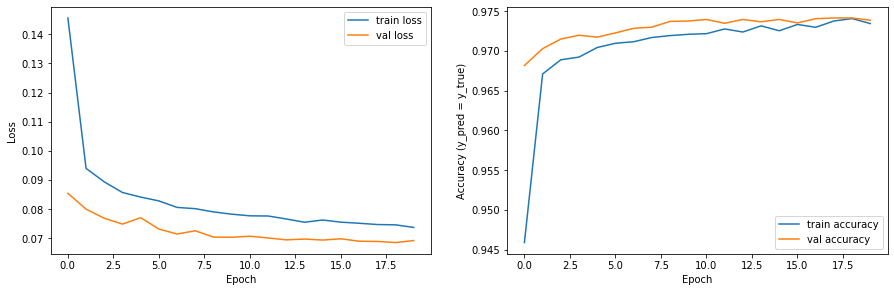

In [35]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [36]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

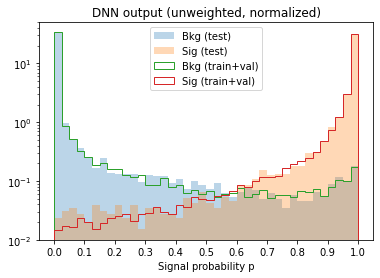

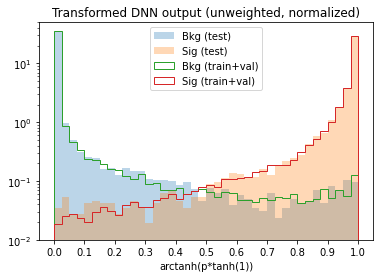

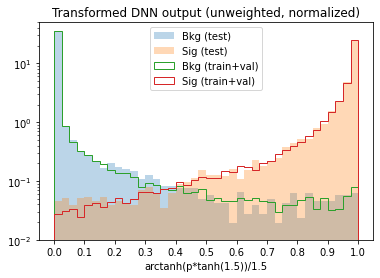

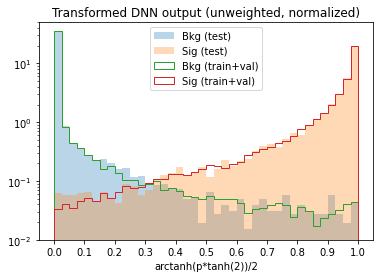

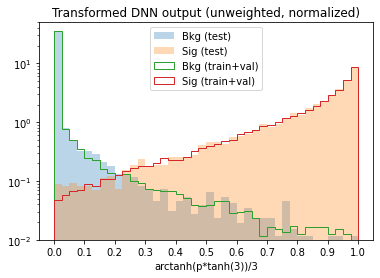

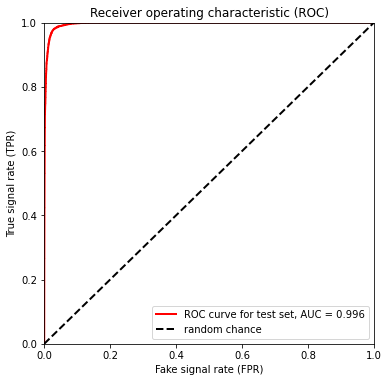

Test loss, test accuracy: [0.07320812435892858, 0.9737706780433655]


In [37]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1.5))/1.5')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,5e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Save trained model

In [38]:
joblib.dump(scaler, 'trained_models_rerunBtag/et1b_scaler.gz')
model.save('trained_models_rerunBtag/et1b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/et1b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/et1b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE, THE BELOW CAN BE IGNORED)

## Load all root files one by one

In [ ]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/et18_raw/'
outfolder18 = 'root_outputs/et18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('etau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/et17_raw/'
outfolder17 = 'root_outputs/et17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('etau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/et16_raw/'
outfolder16 = 'root_outputs/et16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('etau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

## Feed to NN and write outputs to root files

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths16[i])